# Fit timescales of fluxes during zero emissions

Can we find the emergent timescales of land carbon sink? Or total land+ocean sink?

fit using ZEC, test using CDR


Land or ocean sink = response to prior emissions

sink=f(prior emissions with lag)


### Charlie's Model
single timescale model:  
$S(t) = \int_0^t E(t_e) a e^\frac{-(t-t_e)}{\tau} dt_e$ 

two timescale model:  
$S(t) = \int_0^t E(t_e)\Big( a_1 e^\frac{-(t-t_e)}{\tau_1} + a_2 e^\frac{-(t-t_e)}{\tau_2} \Big) dt_e$ 

### IRF model (Joos et al. 2013)
$IRF(t) = a_0 + \sum_{i=1}^3 a_i \cdot exp\Big(\frac{-t}{\tau_i}\Big)$

#### Unknown constants
$\tau_i$  
$a_i$  

#### Optimize against model output 
$nbp$: land flux  
$fgco2$:  ocean flux  
$nbp+fgco2$: (total sink)  


In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
from xarray.coding.times import CFTimedeltaCoder

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True

import glob

## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy


from loading_function_flat10 import load_flat10, load_one_model, load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean 

import dask
from dask import delayed, compute
from dask.distributed import Client


## Data and Metadata

In [2]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
#varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']
### from ben: colors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]


latlist=['global','highlat','troplat','midlat']

markerlist=['o','v','^','<','>','s','*','P','d','X']

vegcolor=color=np.divide([176, 208, 65],255)
littercolor=np.divide([240, 155, 56],255)
soilcolor=np.divide([164, 119, 39],255)

In [3]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [4]:
# load timeseries of data
ds_C_global = xr.open_dataset("C_metrics_matrix_S.nc")

In [5]:
# define emissions time series 

# define emissions time series for flat10+flat10_zec
emiss = np.empty(300)*0
emiss[0:100]=10
#emiss[-100:]=0

emiss_flat10zec=emiss

In [6]:
# emiss

In [7]:
def get_full_ts_flat10(modelname, exp, var, latrange):

    '''
    inputs (modelname, exp, var, latrange)
    outputs (VAR_ts) 
    
    # unit conversions need to be made after this is called
    # GPP_ts= GPP *  speryr #convert from Pg/s to Pg/yr
    # T_tszec = T-273.15
    # RH_tszec= RH *  speryr #convert from Pg/s to Pg/yr
    # NBP_tszec= NBP *  speryr #convert from Pg/s to Pg/yr
    
    '''
    timeseriesE=ds_C_global.sel(model=modelname, run='flat10', 
                                   var=var, latrange=latrange)
    
    timeseries=ds_C_global.sel(model=modelname, run=exp, 
                                   var=var, latrange=latrange)
    
    VAR_ts=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
    
    return VAR_ts


# Define model

In [23]:
# 3 timescale model

# Simulation function
def simulate_model_3tau(tau_params):
    tau1, tau2, tau3, a1, a2, a3 = tau_params
    if tau1 <= 0 or tau2 <= 0 or tau3 <= 0 or a1<=0 or a2<=0 or a3<0 :
        return None  # for bounds enforcement

    n = len(emiss)
    sink = np.zeros(n)

    sink[0] = 0#sink0

    for t in range(1, n):
        # ML[y-1] = max(ML[y-1], 1e-6)
        # MS[y-1] = max(MS[y-1], 1e-6)
        
        # if np.isnan(ML[y-1]) or np.isnan(MS[y-1]) or np.isnan(T[y]) or T[y] == 0:
        #     print(f"Invalid input at step {y}: T={T[y]}, ML[y-1]={ML[y-1]}, MS[y-1]={MS[y-1]},fL={fL},fS={fS}")
        #     return None
        
        sink[t]= sink[t-1] + emiss[t] * dt * (a1 * np.exp(-(n-t)/tau1) + a2 * np.exp(-(n-t)/tau2) + a3 * np.exp(-(n-t)/tau3))

    return sink

# Objective function
def objective_3tau(tau_params):
    result = simulate_model_3tau(tau_params)
    if result is None:
        return np.inf
    sink = result
    # Mean squared error
    loss = (
    np.mean((sink - NBP)**2) * 1.0
    )
    return loss

In [24]:
def model_sink_convolution_3tau(emiss, dt, params):
    # Unpack parameters
    a1, a2, tau1, tau2, tau3 = params
    a3 = 1.0 - a1 - a2  # Enforce a1 + a2 + a3 = 1

    n = len(emiss)
    t = np.arange(n)

    # Compute response kernel
    kernel = (a1 * np.exp(-t / tau1) +
              a2 * np.exp(-t / tau2) +
              a3 * np.exp(-t / tau3))

    # Convolution and integration
    response = dt * np.convolve(emiss, kernel)[:n]
    return np.cumsum(response)

def objective_function_3tau(params, emiss, sink_obs, dt):
    sink_pred = model_sink_convolution_3tau(emiss, dt, params)
    return np.mean((sink_pred - sink_obs)**2)

In [25]:
# curve fit version of the model

def memory_model_3timescale_constrained_safe(emissions, tau1, tau2, tau3, sens1, sens2):
    sens3 = 1.0 - sens1 - sens2

    if sens3 < 0 or sens3 > 1:
        return np.full_like(emissions, 1e10)  # Penalize invalid sensitivity

    nt = len(emissions)
    max_lag = min(nt, int(max(tau1, tau2, tau3) * 10))
    t = np.arange(max_lag)

    kernel = (sens1 * np.exp(-t / tau1) +
              sens2 * np.exp(-t / tau2) +
              sens3 * np.exp(-t / tau3))

    sink = np.convolve(emissions, kernel)[:nt]
    return sink

def residuals_3timescale(params, emissions, sink_obs):
    tau1, tau2, tau3, sens1, sens2 = params
    pred = memory_model_3timescale_constrained_safe(emissions, tau1, tau2, tau3, sens1, sens2)
    return pred - sink_obs


In [26]:
# curve fit version of the model

def memory_model_2timescale_constrained_safe(emissions, tau1, tau2, sens1):
    sens2 = 1.0 - sens1

    if sens2 < 0 or sens2 > 1:
        return np.full_like(emissions, 1e10)  # Penalize invalid sensitivity

    nt = len(emissions)
    max_lag = min(nt, int(max(tau1, tau2) * 10))
    t = np.arange(max_lag)

    kernel = (sens1 * np.exp(-t / tau1) +
              sens2 * np.exp(-t / tau2)
              )

    sink = np.convolve(emissions, kernel)[:nt]
    return sink

def residuals_2timescale(params, emissions, sink_obs):
    tau1, tau2, sens1 = params
    pred = memory_model_2timescale_constrained_safe(emissions, tau1, tau2, sens1)
    return pred - sink_obs


In [27]:
# Charlie's model
# 3 tau
def memory_3timescale_Charlie(emissions, tau1, tau2, tau3, sens1, sens2,sens3):
    nt = len(emissions)
    sink = np.zeros(nt)
    for t in range(nt):
        r = 0
        for tt in range(t):
            r = r + emissions[tt] * (sens1 * np.exp(-(t-tt)/tau1) + sens2 * np.exp(-(t-tt)/tau2)+ sens3 * np.exp(-(t-tt)/tau3))
        sink[t] = r
    return sink


In [28]:
# Charlie's model
# 2 tau
def memory_2timescale_Charlie(emissions, tau1, tau2, sens1, sens2):
    nt = len(emissions)
    sink = np.zeros(nt)
    for t in range(nt):
        r = 0
        for tt in range(t):
            r = r + emissions[tt] * (sens1 * np.exp(-(t-tt)/tau1) + sens2 * np.exp(-(t-tt)/tau2))
        sink[t] = r
    return sink


In [29]:
def memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2):
    nt = len(emissions)
    t = np.arange(nt)
    
    kernel1 = sens1 * np.exp(-t / tau1)
    kernel2 = sens2 * np.exp(-t / tau2)
    kernel = kernel1 + kernel2

    sink = np.convolve(emissions, kernel, mode='full')[:nt]
    return sink

# Wrapper function for curve_fit: emissions is fixed, other params are free
def fit_wrapper2(t, tau1, tau2, sens1, sens2):
    return memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2)


# Wrapper function for fitting each point (i, j)
def fit_wrapper2_grid(t, emissions, observed):
    def model(t, tau1, tau2, sens1, sens2):
        return memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2)
    return model(t, *params)

In [30]:
def memory_3timescale_vectorized(emissions, tau1, tau2, tau3, sens1, sens2, sens3):
    nt = len(emissions)
    t = np.arange(nt)
    
    kernel1 = sens1 * np.exp(-t / tau1)
    kernel2 = sens2 * np.exp(-t / tau2)
    kernel3 = sens3 * np.exp(-t / tau3)
    kernel = kernel1 + kernel2 + kernel3

    sink = np.convolve(emissions, kernel, mode='full')[:nt]
    return sink

# Define a wrapper for curve_fit
def fit_wrapper3(t, tau1, tau2, tau3, sens1, sens2, sens3):
    return memory_3timescale_vectorized(emissions, tau1, tau2, tau3, sens1, sens2, sens3)

# # Example fitting
# popt, pcov = curve_fit(fit_wrapper, np.arange(len(emissions)), observed,
#                        bounds=([1, 1, 1, -np.inf, -np.inf, -np.inf], [1000, 1000, 1000, np.inf, np.inf, np.inf]))

# Fit model

estimating parameters for model: ACCESS-ESM1-5
taus: 0.50, 3.37
sensitivities: 0.100, 0.016


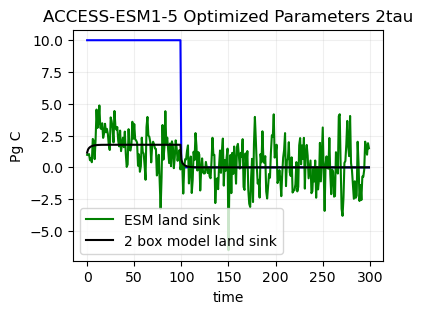

estimating parameters for model: CESM2
taus: 3.48, 28.03
sensitivities: 0.023, 0.010


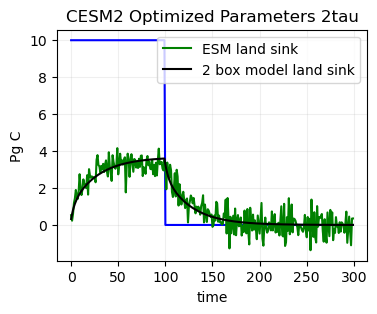

estimating parameters for model: GFDL-ESM4
taus: 0.77, 25.04
sensitivities: 0.072, 0.008


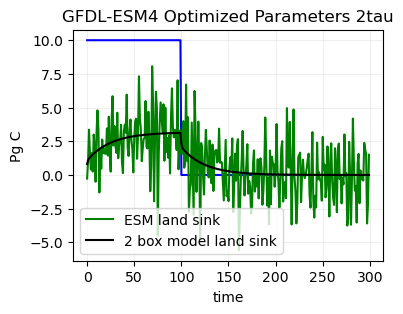

estimating parameters for model: GISS_E2.1
taus: 0.50, 9.22
sensitivities: 0.008, 0.006


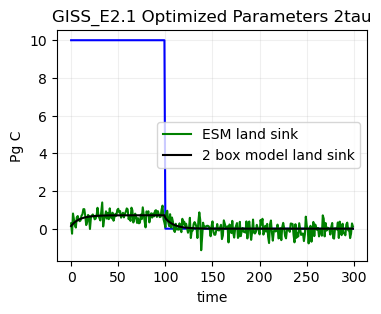

estimating parameters for model: NorESM2-LM
taus: 5.45, 22.87
sensitivities: 0.010, 0.013


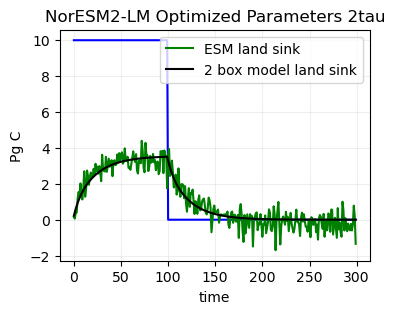

estimating parameters for model: MPI-ESM1-2-LR
taus: 0.50, 25.21
sensitivities: 0.116, 0.009


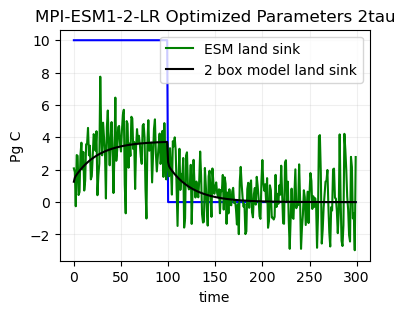

estimating parameters for model: CNRM-ESM2-1
taus: 2.36, 18.19
sensitivities: 0.010, 0.018


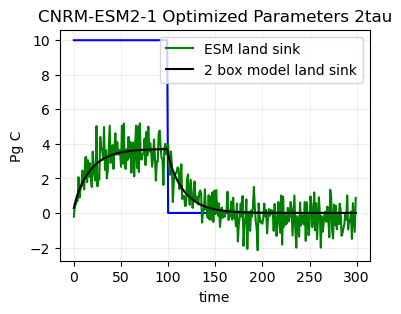

estimating parameters for model: HadCM3LC-Bris
taus: 0.50, 9.00
sensitivities: 0.085, 0.026


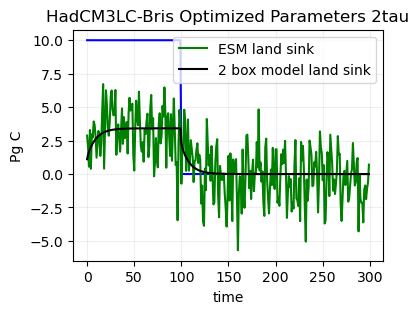

In [31]:
latrange='global'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year

# initialize some empty arrays to store outputs
tau1_vec=np.empty(len(modellist))
tau2_vec=np.empty(len(modellist))
sens1_vec=np.empty(len(modellist))
sens2_vec=np.empty(len(modellist))


# define the emissions time series
emiss=emiss_flat10zec
emissions=emiss

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output
  
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    sink_obs=NBP

    #--- model fit
    # initial guess
    p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, tau3, sens1, sens2

    # bounds
    bounds_lower = [0.5, 1.0, 0.0, 0.0]
    bounds_upper = [100.0, 1000.0, 1.0,1.0]


    # fit using curve_fit and Charlie's model
    # params_combined_2timescale, fit_combined_2timescale = scipy.optimize.curve_fit(memory_2timescale_Charlie,emiss, sink_obs,p0) 

    # tau1, tau2,  sens1, sens2 = params_combined_2timescale
    # #sens2=1-(sens1)                                                               
    # pred_landsink_Charlie = memory_2timescale_Charlie(emiss, 
    #                                tau1, 
    #                                tau2,
    #                                sens1,
    #                                sens2)

    # Example data
    # emissions: your input time series (1D np.array)
    # observed: the corresponding observed response (same shape)
    
    popt, pcov = curve_fit(fit_wrapper2, np.arange(len(emiss)), sink_obs,
                           bounds=(bounds_lower, bounds_upper))

    tau1, tau2,  sens1, sens2 = popt
    box_model_pred_2=fit_wrapper2(np.arange(len(emiss)),tau1,tau2,sens1,sens2)

    # # Extract parameters
    # tau1, tau2,  sens1 = popt
    # sens2=1-(sens1)
    print(f"taus: {tau1:.2f}, {tau2:.2f}")
    print(f"sensitivities: {sens1:.3f}, {sens2:.3f}")
    
    
    # pred_totalsink_2timescale_zec = memory_model_2timescale_constrained_safe(emiss, 
    #                                                   tau1, 
    #                                                   tau2,  
    #                                                   sens1
    #                                                  )

    plt.figure(figsize=(4, 3))    
    plt.plot(emiss, color='blue')
    plt.plot(sink_obs, color='green',label='ESM land sink')
    plt.plot(box_model_pred_2, color='black',label='2 box model land sink')
    
    # plt.plot(pred_landsink_Charlie, color='purple',label='Charlies version',linestyle='--')
    # plt.title('Carbon Fluxes, flat10-zec')
    plt.title(model +' Optimized Parameters 2tau' )
    plt.ylabel('Pg C')
    plt.xlabel('time')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


    tau1_vec[m]=tau1
    tau2_vec[m]=tau2
    sens1_vec[m]=sens1
    sens2_vec[m]=sens2
    
# #-- add output to a pandas data frame
esm_boxfit = pd.DataFrame({})
esm_boxfit['tau1']=tau1_vec
esm_boxfit['tau2']=tau2_vec
esm_boxfit['sens1']=sens1_vec
esm_boxfit['sens2']=sens2_vec

esm_boxfit.index=modellist

esm_boxfit_global_zec=esm_boxfit

estimating parameters for model: ACCESS-ESM1-5
taus: 0.50, 6.50
sensitivities: 0.000, 0.003


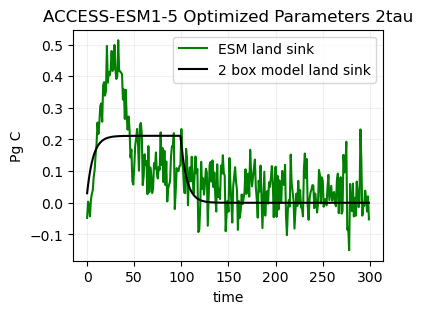

estimating parameters for model: CESM2
taus: 0.60, 68.96
sensitivities: 0.006, 0.000


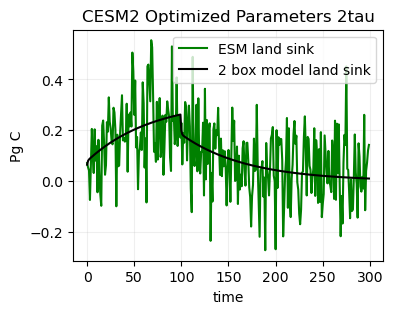

estimating parameters for model: GFDL-ESM4
taus: 18.59, 113.01
sensitivities: 0.001, 0.001


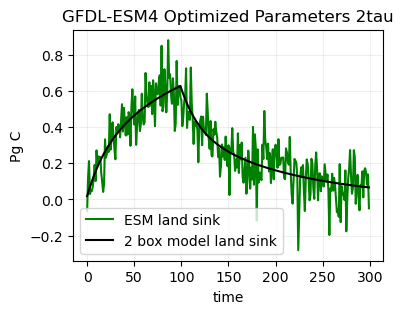

estimating parameters for model: GISS_E2.1
taus: 0.51, 2.09
sensitivities: 0.000, 0.001


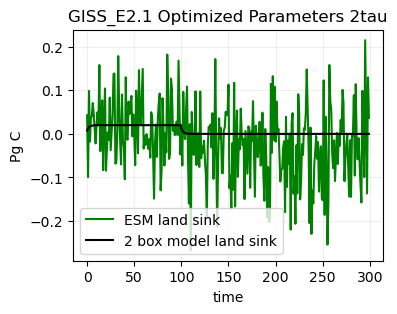

estimating parameters for model: NorESM2-LM
taus: 0.50, 21.80
sensitivities: 0.001, 0.000


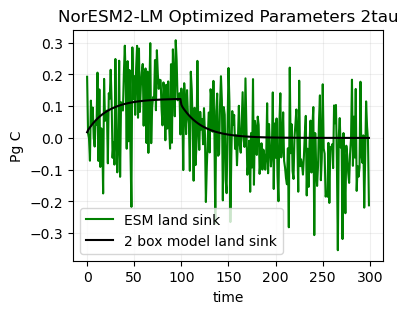

estimating parameters for model: MPI-ESM1-2-LR
taus: 0.86, 200.40
sensitivities: 0.006, 0.000


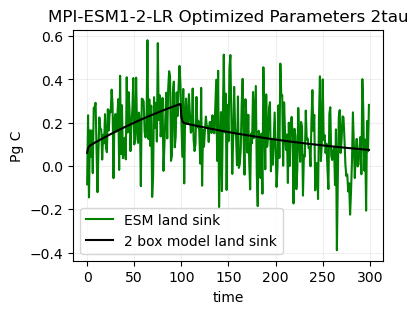

estimating parameters for model: CNRM-ESM2-1
taus: 1.62, 38.16
sensitivities: 0.004, 0.002


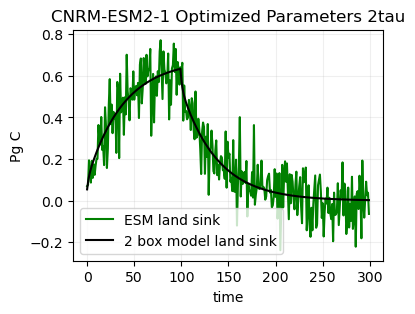

estimating parameters for model: HadCM3LC-Bris
taus: 11.12, 41.45
sensitivities: 0.003, 0.000


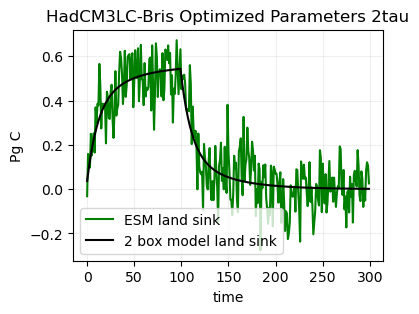

In [32]:
latrange='highlat'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year

# initialize some empty arrays to store outputs
tau1_vec=np.empty(len(modellist))
tau2_vec=np.empty(len(modellist))
sens1_vec=np.empty(len(modellist))
sens2_vec=np.empty(len(modellist))


# define the emissions time series
emiss=emiss_flat10zec
emissions=emiss

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output
  
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    sink_obs=NBP

    #--- model fit
    # initial guess
    p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, tau3, sens1, sens2

    # bounds
    bounds_lower = [0.5, 1.0, 0.0, 0.0]
    bounds_upper = [100.0, 1000.0, 1.0,1.0]


    # fit using curve_fit and Charlie's model
    # params_combined_2timescale, fit_combined_2timescale = scipy.optimize.curve_fit(memory_2timescale_Charlie,emiss, sink_obs,p0) 

    # tau1, tau2,  sens1, sens2 = params_combined_2timescale
    # #sens2=1-(sens1)                                                               
    # pred_landsink_Charlie = memory_2timescale_Charlie(emiss, 
    #                                tau1, 
    #                                tau2,
    #                                sens1,
    #                                sens2)

    # Example data
    # emissions: your input time series (1D np.array)
    # observed: the corresponding observed response (same shape)
    
    popt, pcov = curve_fit(fit_wrapper2, np.arange(len(emiss)), sink_obs,
                           bounds=(bounds_lower, bounds_upper))

    tau1, tau2,  sens1, sens2 = popt
    box_model_pred_2=fit_wrapper2(np.arange(len(emiss)),tau1,tau2,sens1,sens2)

    # # Extract parameters
    # tau1, tau2,  sens1 = popt
    # sens2=1-(sens1)
    print(f"taus: {tau1:.2f}, {tau2:.2f}")
    print(f"sensitivities: {sens1:.3f}, {sens2:.3f}")
    
    
    # pred_totalsink_2timescale_zec = memory_model_2timescale_constrained_safe(emiss, 
    #                                                   tau1, 
    #                                                   tau2,  
    #                                                   sens1
    #                                                  )

    plt.figure(figsize=(4, 3))    
    # plt.plot(emiss, color='blue')
    plt.plot(sink_obs, color='green',label='ESM land sink')
    plt.plot(box_model_pred_2, color='black',label='2 box model land sink')
    
    # plt.plot(pred_landsink_Charlie, color='purple',label='Charlies version',linestyle='--')
    # plt.title('Carbon Fluxes, flat10-zec')
    plt.title(model +' Optimized Parameters 2tau' )
    plt.ylabel('Pg C')
    plt.xlabel('time')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


    tau1_vec[m]=tau1
    tau2_vec[m]=tau2
    sens1_vec[m]=sens1
    sens2_vec[m]=sens2
    
# #-- add output to a pandas data frame
esm_boxfit = pd.DataFrame({})
esm_boxfit['tau1']=tau1_vec
esm_boxfit['tau2']=tau2_vec
esm_boxfit['sens1']=sens1_vec
esm_boxfit['sens2']=sens2_vec

esm_boxfit.index=modellist

esm_boxfit_highlat_zec=esm_boxfit

estimating parameters for model: ACCESS-ESM1-5
taus: 0.50, 4.08
sensitivities: 0.038, 0.008


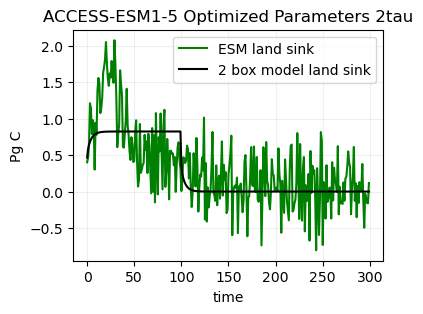

estimating parameters for model: CESM2
taus: 5.90, 63.54
sensitivities: 0.005, 0.001


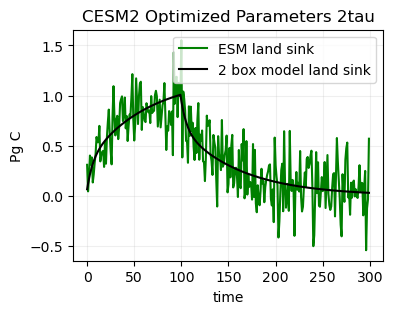

estimating parameters for model: GFDL-ESM4
taus: 0.50, 32.45
sensitivities: 0.018, 0.003


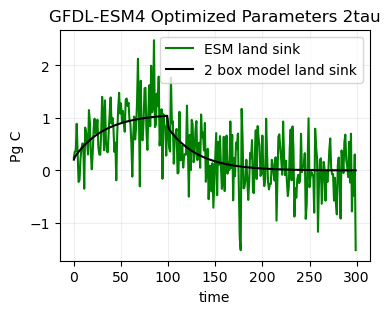

estimating parameters for model: GISS_E2.1
taus: 0.50, 19.62
sensitivities: 0.008, 0.001


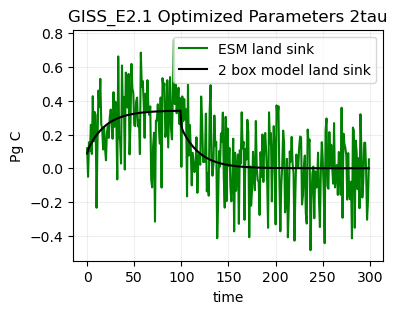

estimating parameters for model: NorESM2-LM
taus: 8.89, 58.39
sensitivities: 0.003, 0.001


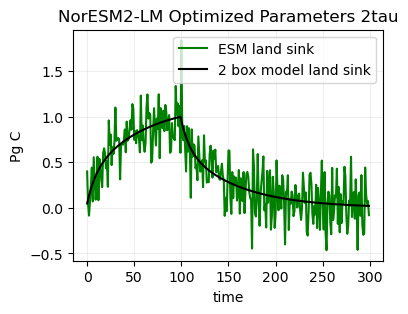

estimating parameters for model: MPI-ESM1-2-LR
taus: 2.07, 96.22
sensitivities: 0.017, 0.001


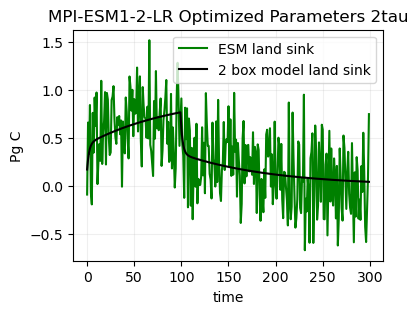

estimating parameters for model: CNRM-ESM2-1
taus: 5.81, 25.64
sensitivities: 0.001, 0.007


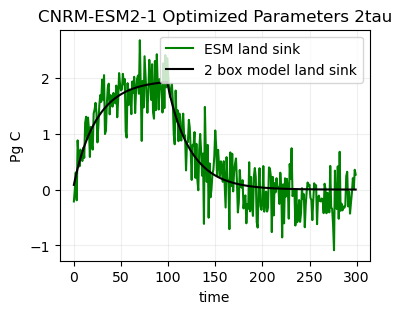

estimating parameters for model: HadCM3LC-Bris
taus: 75.12, 9.19
sensitivities: 0.000, 0.011


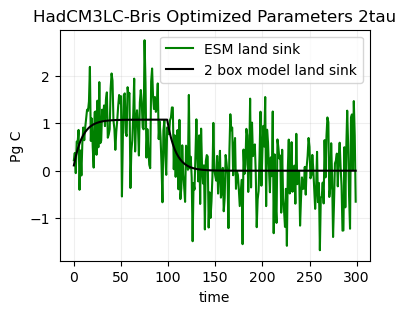

In [33]:
latrange='midlat'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year

# initialize some empty arrays to store outputs
tau1_vec=np.empty(len(modellist))
tau2_vec=np.empty(len(modellist))
sens1_vec=np.empty(len(modellist))
sens2_vec=np.empty(len(modellist))


# define the emissions time series
emiss=emiss_flat10zec
emissions=emiss

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output
  
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    sink_obs=NBP

    #--- model fit
    # initial guess
    p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, tau3, sens1, sens2

    # bounds
    bounds_lower = [0.5, 1.0, 0.0, 0.0]
    bounds_upper = [100.0, 1000.0, 1.0,1.0]


    # fit using curve_fit and Charlie's model
    # params_combined_2timescale, fit_combined_2timescale = scipy.optimize.curve_fit(memory_2timescale_Charlie,emiss, sink_obs,p0) 

    # tau1, tau2,  sens1, sens2 = params_combined_2timescale
    # #sens2=1-(sens1)                                                               
    # pred_landsink_Charlie = memory_2timescale_Charlie(emiss, 
    #                                tau1, 
    #                                tau2,
    #                                sens1,
    #                                sens2)

    # Example data
    # emissions: your input time series (1D np.array)
    # observed: the corresponding observed response (same shape)
    
    popt, pcov = curve_fit(fit_wrapper2, np.arange(len(emiss)), sink_obs,
                           bounds=(bounds_lower, bounds_upper))

    tau1, tau2,  sens1, sens2 = popt
    box_model_pred_2=fit_wrapper2(np.arange(len(emiss)),tau1,tau2,sens1,sens2)

    # # Extract parameters
    # tau1, tau2,  sens1 = popt
    # sens2=1-(sens1)
    print(f"taus: {tau1:.2f}, {tau2:.2f}")
    print(f"sensitivities: {sens1:.3f}, {sens2:.3f}")
    
    
    # pred_totalsink_2timescale_zec = memory_model_2timescale_constrained_safe(emiss, 
    #                                                   tau1, 
    #                                                   tau2,  
    #                                                   sens1
    #                                                  )

    plt.figure(figsize=(4, 3))    
    # plt.plot(emiss, color='blue')
    plt.plot(sink_obs, color='green',label='ESM land sink')
    plt.plot(box_model_pred_2, color='black',label='2 box model land sink')
    
    # plt.plot(pred_landsink_Charlie, color='purple',label='Charlies version',linestyle='--')
    # plt.title('Carbon Fluxes, flat10-zec')
    plt.title(model +' Optimized Parameters 2tau' )
    plt.ylabel('Pg C')
    plt.xlabel('time')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


    tau1_vec[m]=tau1
    tau2_vec[m]=tau2
    sens1_vec[m]=sens1
    sens2_vec[m]=sens2
    
# #-- add output to a pandas data frame
esm_boxfit = pd.DataFrame({})
esm_boxfit['tau1']=tau1_vec
esm_boxfit['tau2']=tau2_vec
esm_boxfit['sens1']=sens1_vec
esm_boxfit['sens2']=sens2_vec

esm_boxfit.index=modellist

esm_boxfit_midlat_zec=esm_boxfit

estimating parameters for model: ACCESS-ESM1-5
taus: 0.55, 1.00
sensitivities: 0.063, 0.000


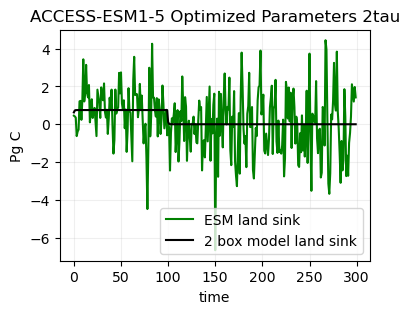

estimating parameters for model: CESM2
taus: 0.50, 16.25
sensitivities: 0.020, 0.012


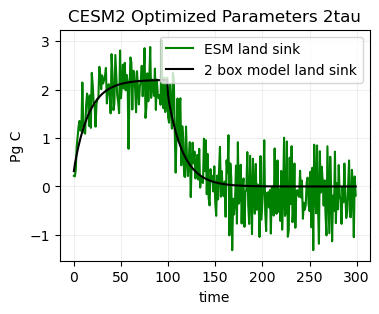

estimating parameters for model: GFDL-ESM4
taus: 0.50, 7.24
sensitivities: 0.035, 0.013


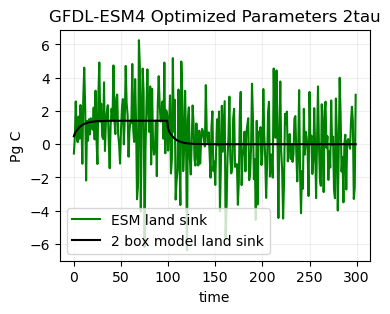

estimating parameters for model: GISS_E2.1
taus: 0.50, 6.91
sensitivities: 0.003, 0.004


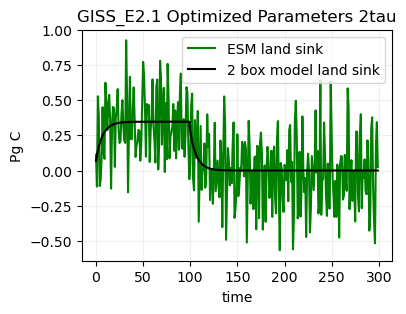

estimating parameters for model: NorESM2-LM
taus: 3.73, 14.93
sensitivities: 0.000, 0.015


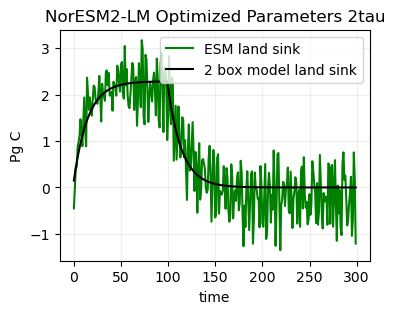

estimating parameters for model: MPI-ESM1-2-LR
taus: 0.50, 14.45
sensitivities: 0.046, 0.013


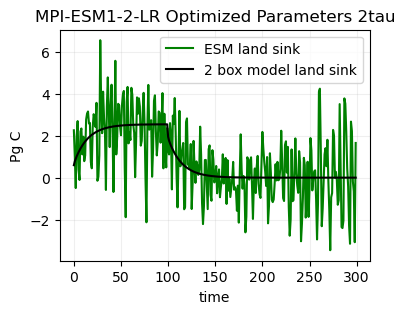

estimating parameters for model: CNRM-ESM2-1
taus: 5.59, 6.09
sensitivities: 0.017, 0.000


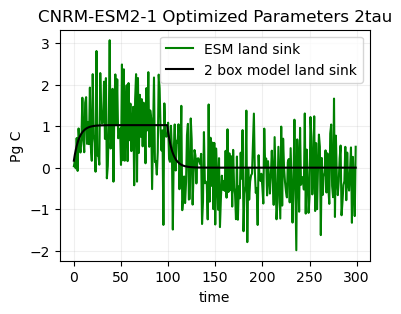

estimating parameters for model: HadCM3LC-Bris
taus: 0.50, 8.92
sensitivities: 0.103, 0.007


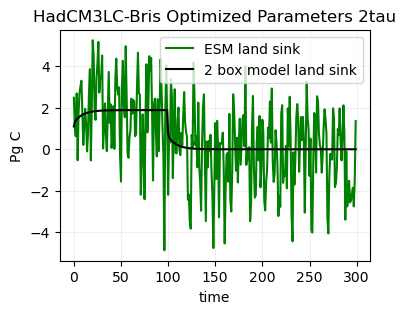

In [34]:
latrange='troplat'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year

# initialize some empty arrays to store outputs
tau1_vec=np.empty(len(modellist))
tau2_vec=np.empty(len(modellist))
sens1_vec=np.empty(len(modellist))
sens2_vec=np.empty(len(modellist))


# define the emissions time series
emiss=emiss_flat10zec
emissions=emiss

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output
  
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    sink_obs=NBP

    #--- model fit
    # initial guess
    p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, tau3, sens1, sens2

    # bounds
    bounds_lower = [0.5, 1.0, 0.0, 0.0]
    bounds_upper = [100.0, 1000.0, 1.0,1.0]


    # fit using curve_fit and Charlie's model
    # params_combined_2timescale, fit_combined_2timescale = scipy.optimize.curve_fit(memory_2timescale_Charlie,emiss, sink_obs,p0) 

    # tau1, tau2,  sens1, sens2 = params_combined_2timescale
    # #sens2=1-(sens1)                                                               
    # pred_landsink_Charlie = memory_2timescale_Charlie(emiss, 
    #                                tau1, 
    #                                tau2,
    #                                sens1,
    #                                sens2)

    # Example data
    # emissions: your input time series (1D np.array)
    # observed: the corresponding observed response (same shape)
    
    popt, pcov = curve_fit(fit_wrapper2, np.arange(len(emiss)), sink_obs,
                           bounds=(bounds_lower, bounds_upper))

    tau1, tau2,  sens1, sens2 = popt
    box_model_pred_2=fit_wrapper2(np.arange(len(emiss)),tau1,tau2,sens1,sens2)

    # # Extract parameters
    # tau1, tau2,  sens1 = popt
    # sens2=1-(sens1)
    print(f"taus: {tau1:.2f}, {tau2:.2f}")
    print(f"sensitivities: {sens1:.3f}, {sens2:.3f}")
    
    
    # pred_totalsink_2timescale_zec = memory_model_2timescale_constrained_safe(emiss, 
    #                                                   tau1, 
    #                                                   tau2,  
    #                                                   sens1
    #                                                  )

    plt.figure(figsize=(4, 3))    
    # plt.plot(emiss, color='blue')
    plt.plot(sink_obs, color='green',label='ESM land sink')
    plt.plot(box_model_pred_2, color='black',label='2 box model land sink')
    
    # plt.plot(pred_landsink_Charlie, color='purple',label='Charlies version',linestyle='--')
    # plt.title('Carbon Fluxes, flat10-zec')
    plt.title(model +' Optimized Parameters 2tau' )
    plt.ylabel('Pg C')
    plt.xlabel('time')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


    tau1_vec[m]=tau1
    tau2_vec[m]=tau2
    sens1_vec[m]=sens1
    sens2_vec[m]=sens2
    
# #-- add output to a pandas data frame
esm_boxfit = pd.DataFrame({})
esm_boxfit['tau1']=tau1_vec
esm_boxfit['tau2']=tau2_vec
esm_boxfit['sens1']=sens1_vec
esm_boxfit['sens2']=sens2_vec

esm_boxfit.index=modellist

esm_boxfit_troplat_zec=esm_boxfit

Text(0.5, 0.98, 'global flat10_zec')

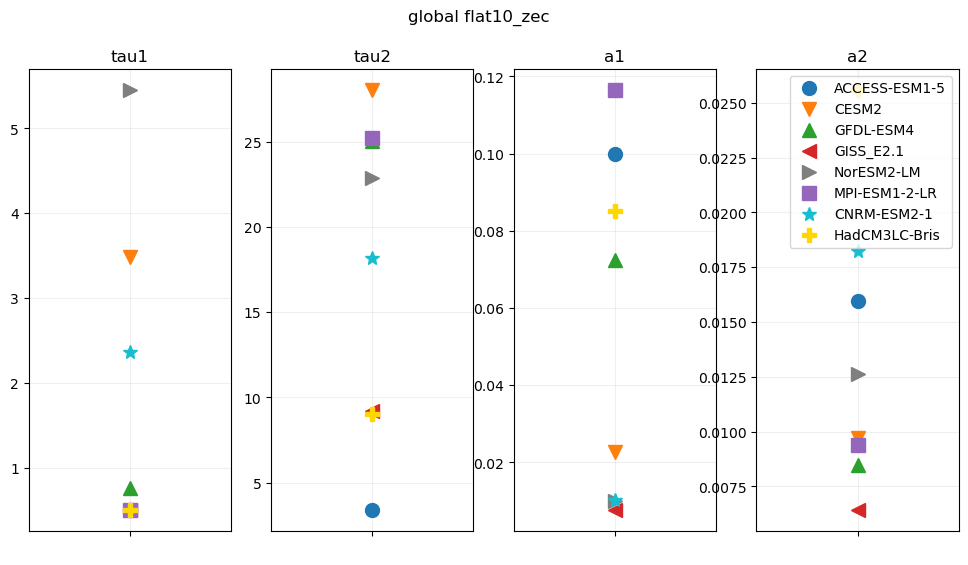

In [35]:
# plot the params


latrange='global'
experiment='flat10_zec'

esm_boxfit = esm_boxfit_global_zec

fig, ax =plt.subplots(1,4,figsize=(12, 6))

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(1, esm_boxfit['tau1'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[1].plot(1, esm_boxfit['tau2'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[2].plot(1, esm_boxfit['sens1'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[3].plot(1, esm_boxfit['sens2'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)


ax[0].set_title('tau1')
ax[1].set_title('tau2')
ax[2].set_title('a1')
ax[3].set_title('a2')

for axi in range(len(ax)):
    ax[axi].grid(alpha=0.2)
    # ax[axi].axhline(0,lw=0.8,color="gray",linestyle=":")
    # ax[axi].set_ylim([-40,60])
    ax[axi].xaxis.set_ticks([1])
    ax[axi].xaxis.set_tick_params(labelcolor='none')
    # if axi>0:
    #     ax[axi].yaxis.set_tick_params(labelcolor='none')
        
# ax[0].grid(alpha=0.2)
# ax[1].grid(alpha=0.2)
# ax[2].grid(alpha=0.2)
# ax[3].grid(alpha=0.2)

ax[3].legend()

fig.suptitle(latrange +' ' +experiment)

# plt.savefig('figures/box_model_params_fit_' +latrange +'_' +experiment +'.pdf', bbox_inches='tight')



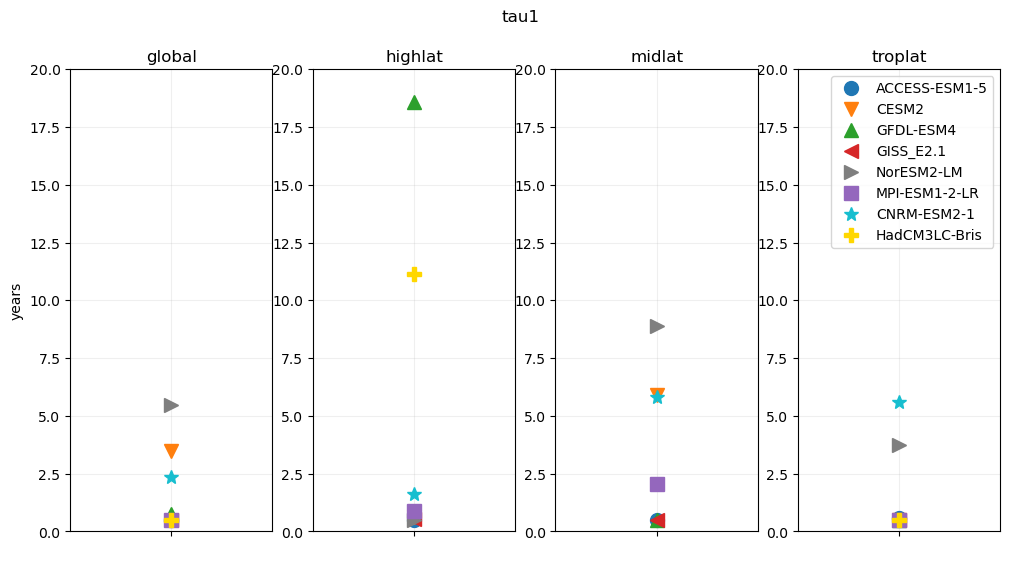

In [36]:
# plot the params


latrange='highlat'
experiment='flat10_zec'

# esm_boxfit = esm_boxfit_highlat_zec

fig, ax =plt.subplots(1,4,figsize=(12, 6))

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(1, esm_boxfit_global_zec['tau1'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[1].plot(1, esm_boxfit_highlat_zec['tau1'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[2].plot(1, esm_boxfit_midlat_zec['tau1'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[3].plot(1, esm_boxfit_troplat_zec['tau1'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)


ax[0].set_title('global')
ax[1].set_title('highlat')
ax[2].set_title('midlat')
ax[3].set_title('troplat')

ax[0].set_ylabel('years')

for axi in range(len(ax)):
    ax[axi].grid(alpha=0.2)
    # ax[axi].axhline(0,lw=0.8,color="gray",linestyle=":")
    ax[axi].set_ylim([0,20])
    ax[axi].xaxis.set_ticks([1])
    ax[axi].xaxis.set_tick_params(labelcolor='none')
    # if axi>0:
    #     ax[axi].yaxis.set_tick_params(labelcolor='none')
        
# ax[0].grid(alpha=0.2)
# ax[1].grid(alpha=0.2)
# ax[2].grid(alpha=0.2)
# ax[3].grid(alpha=0.2)

ax[3].legend()

fig.suptitle('tau1')

plt.savefig('figures/box_model_tau1_fit_' +experiment +'.pdf', bbox_inches='tight')



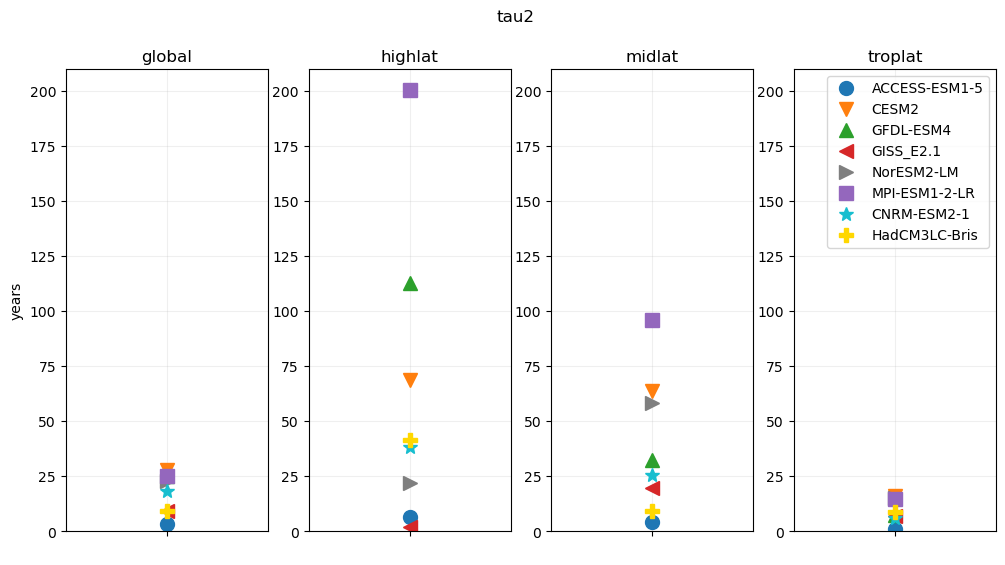

In [37]:
# plot the params


# latrange='highlat'
experiment='flat10_zec'

# esm_boxfit = esm_boxfit_highlat_zec

fig, ax =plt.subplots(1,4,figsize=(12, 6))

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(1, esm_boxfit_global_zec['tau2'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[1].plot(1, esm_boxfit_highlat_zec['tau2'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[2].plot(1, esm_boxfit_midlat_zec['tau2'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[3].plot(1, esm_boxfit_troplat_zec['tau2'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)


ax[0].set_title('global')
ax[1].set_title('highlat')
ax[2].set_title('midlat')
ax[3].set_title('troplat')

ax[0].set_ylabel('years')

for axi in range(len(ax)):
    ax[axi].grid(alpha=0.2)
    # ax[axi].axhline(0,lw=0.8,color="gray",linestyle=":")
    ax[axi].set_ylim([0,210])
    ax[axi].xaxis.set_ticks([1])
    ax[axi].xaxis.set_tick_params(labelcolor='none')
    # if axi>0:
    #     ax[axi].yaxis.set_tick_params(labelcolor='none')
        
# ax[0].grid(alpha=0.2)
# ax[1].grid(alpha=0.2)
# ax[2].grid(alpha=0.2)
# ax[3].grid(alpha=0.2)

ax[3].legend()

fig.suptitle('tau2')

plt.savefig('figures/box_model_tau2_fit_' +experiment +'.pdf', bbox_inches='tight')



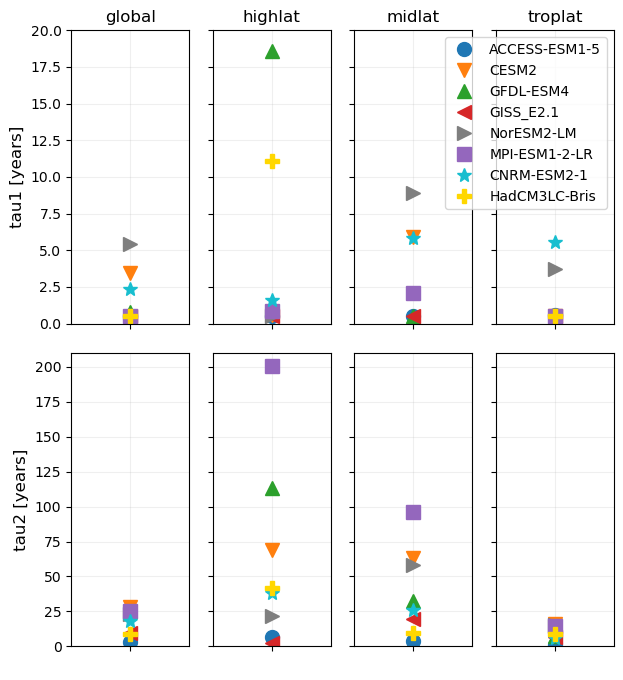

In [56]:
# plot the params


# latrange='highlat'
experiment='flat10_zec'

# esm_boxfit = esm_boxfit_highlat_zec

fig, ax =plt.subplots(2,4,figsize=(7, 8))

taulist=['tau1','tau2']

for m in range(len(modellist)):
    model=modellist[m]
    for t in range(len(taulist)):
        tau=taulist[t]
        
        ax[t,0].plot(1, esm_boxfit_global_zec[tau][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
        ax[t,1].plot(1, esm_boxfit_highlat_zec[tau][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
        ax[t,2].plot(1, esm_boxfit_midlat_zec[tau][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
        ax[t,3].plot(1, esm_boxfit_troplat_zec[tau][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)

        ax[t,0].set_ylabel(tau +' [years]',fontsize=12)

ax[0,0].set_title('global')
ax[0,1].set_title('highlat')
ax[0,2].set_title('midlat')
ax[0,3].set_title('troplat')


nr, nc = np.shape(ax)
for r in range(nr):
    for c in range(nc):
        ax[r,c].grid(alpha=0.2)
        # ax[axi].axhline(0,lw=0.8,color="gray",linestyle=":")
        ax[0,c].set_ylim([0,20]) #tau1
        ax[1,c].set_ylim([0,210]) #tau2
        ax[r,c].xaxis.set_ticks([1])
        ax[r,c].xaxis.set_tick_params(labelcolor='none')
        if c>0:
            ax[r,c].yaxis.set_tick_params(labelcolor='none')
        
# ax[0].grid(alpha=0.2)
# ax[1].grid(alpha=0.2)
# ax[2].grid(alpha=0.2)
# ax[3].grid(alpha=0.2)

ax[0,3].legend()
# fig.tight_layout()
# subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.subplots_adjust(hspace=0.1)

# fig.suptitle('tau2')

plt.savefig('figures/box_model_bothtau_fit_' +experiment +'.pdf', bbox_inches='tight')



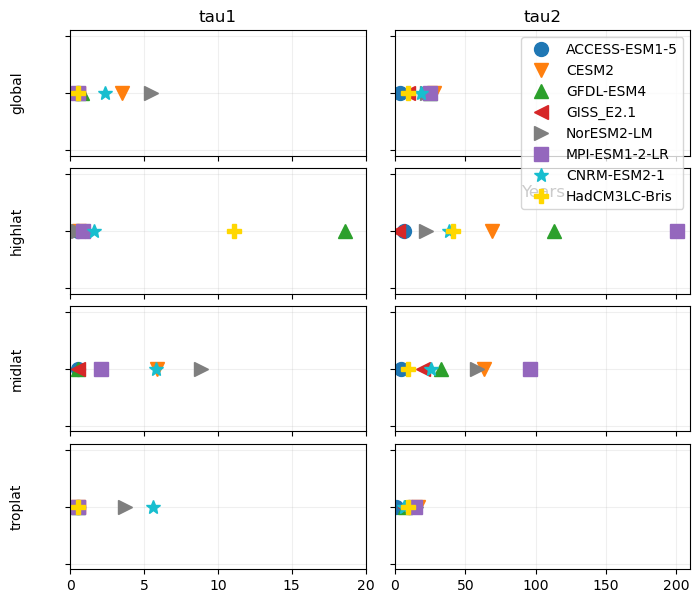

<Figure size 640x480 with 0 Axes>

In [80]:
# plot the params, sideways


# latrange='highlat'
experiment='flat10_zec'

# esm_boxfit = esm_boxfit_highlat_zec

fig, ax =plt.subplots(4,2,figsize=(8, 7))

taulist=['tau1','tau2']

for m in range(len(modellist)):
    model=modellist[m]
    for t in range(len(taulist)):
        tau=taulist[t]
        
        ax[0,t].plot(esm_boxfit_global_zec[tau][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
        ax[1,t].plot(esm_boxfit_highlat_zec[tau][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
        ax[2,t].plot(esm_boxfit_midlat_zec[tau][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
        ax[3,t].plot(esm_boxfit_troplat_zec[tau][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)

        ax[0,t].set_title(tau,fontsize=12)

ax[0,0].set_ylabel('global')
ax[1,0].set_ylabel('highlat')
ax[2,0].set_ylabel('midlat')
ax[3,0].set_ylabel('troplat')


nr, nc = np.shape(ax)
for r in range(nr):
    for c in range(nc):
        ax[r,c].grid(alpha=0.2)
        # ax[axi].axhline(0,lw=0.8,color="gray",linestyle=":")
        ax[r,0].set_xlim([0,20]) #tau1
        ax[r,1].set_xlim([0,210]) #tau2
        # ax[r,c].xaxis.set_ticks([1])
        ax[r,c].yaxis.set_tick_params(labelcolor='none')
        if r<nr-1:
            ax[r,c].xaxis.set_tick_params(labelcolor='none')
        if r
            ax[r,c].set_xlabel('Years',fontsize=12)
        
        
# ax[0].grid(alpha=0.2)
# ax[1].grid(alpha=0.2)
# ax[2].grid(alpha=0.2)
# ax[3].grid(alpha=0.2)

lgax=ax[0,1].legend()
ax[0,1].set_zorder(150) # move legend to the top

# fig.tight_layout()
# subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.subplots_adjust(hspace=0.1,wspace=0.1)

# fig.suptitle('tau2')

plt.show()

plt.savefig('figures/box_model_bothtau_fit_sideways_' +experiment +'.pdf', bbox_inches='tight')



<bound method Artist.get_zorder of <Axes: title={'center': 'tau2 [years]'}>>


# Fit for zonal mean

In [8]:
# initialize a dictionary to hold grid data
data_dict={}
data_dict = load_grid(data_dict,modellist)

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
HadCM3LC-Bris getting grid info
UKESM1.2 getting grid info


In [9]:
def memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2):
    if not np.isfinite(tau1) or not np.isfinite(tau2):
        print(f"Bad tau values: tau1={tau1}, tau2={tau2}")
    if tau1 <= 0 or tau2 <= 0:
        print(f"Non-positive tau values: tau1={tau1}, tau2={tau2}")
        
    nt = len(emissions)
    t = np.arange(nt)
    
    kernel1 = sens1 * np.exp(-t / tau1)
    kernel2 = sens2 * np.exp(-t / tau2)
    kernel = kernel1 + kernel2

    sink = np.convolve(emissions, kernel, mode='full')[:nt]
    return sink

# Define a local wrapper with emissions fixed
def fit_wrapper_2tau_vector(t, tau1, tau2, sens1, sens2):
    return memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2)

In [10]:
# Charlie's model
# 2 tau
def memory_2timescale_Charlie(emissions, tau1, tau2, sens1, sens2):
    nt = len(emissions)
    sink = np.zeros(nt)
    for t in range(nt):
        r = 0
        for tt in range(t):
            r = r + emissions[tt] * (sens1 * np.exp(-(t-tt)/tau1) + sens2 * np.exp(-(t-tt)/tau2))
        sink[t] = r
    return sink


In [13]:
'''def fit_zonal_2timescale(emissions, observed_grid):
    """
    Fit a 2-timescale exponential decay model to each grid point of the observed time series.

    Parameters:
        emissions (1D array): Input emissions time series (length T)
        observed_grid (2D array): Observed response (shape T x M )

    Returns:
        param_grid (2D array): Optimized parameters for each grid point (shape M x 4)
    """
    t_len, m = observed_grid.shape
    param_grid = np.full((m, 4), np.nan)  # Store parameters (tau1, tau2, sens1, sens2)

    # Initial guess and bounds for curve fitting
    p0 = [2.0, 10.0, 0.02, 0.001]
    bounds_lower = [0.5, 1.0, 0.0, 0.0]
    bounds_upper = [100.0, 1000.0, 1.0, 1.0]
    bounds = (bounds_lower, bounds_upper)

    time = np.arange(len(emissions))

    for i in range(m):
        observed = observed_grid[:, i]

        # Skip if data is all NaNs
        if np.isnan(observed).all():
            continue

        # Define a local wrapper with emissions fixed
        def model_to_fit(t, tau1, tau2, sens1, sens2):
            return memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2)

        try:
            popt, _ = curve_fit(model_to_fit, time, observed, p0=p0, bounds=bounds)
            param_grid[i, :] = popt
        except Exception as e:
            print(f"Fit failed at grid point ({i}): {e}")

    return param_grid
'''

'def fit_zonal_2timescale(emissions, observed_grid):\n    """\n    Fit a 2-timescale exponential decay model to each grid point of the observed time series.\n\n    Parameters:\n        emissions (1D array): Input emissions time series (length T)\n        observed_grid (2D array): Observed response (shape T x M )\n\n    Returns:\n        param_grid (2D array): Optimized parameters for each grid point (shape M x 4)\n    """\n    t_len, m = observed_grid.shape\n    param_grid = np.full((m, 4), np.nan)  # Store parameters (tau1, tau2, sens1, sens2)\n\n    # Initial guess and bounds for curve fitting\n    p0 = [2.0, 10.0, 0.02, 0.001]\n    bounds_lower = [0.5, 1.0, 0.0, 0.0]\n    bounds_upper = [100.0, 1000.0, 1.0, 1.0]\n    bounds = (bounds_lower, bounds_upper)\n\n    time = np.arange(len(emissions))\n\n    for i in range(m):\n        observed = observed_grid[:, i]\n\n        # Skip if data is all NaNs\n        if np.isnan(observed).all():\n            continue\n\n        # Define a local 

In [11]:
# fit every zonal band
# Create a Dask client with 8 workers 

# client = Client(n_workers=8)

params_dict={}

#--- model fit bounds and initial guesses
# initial guess
p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, sens1, sens2

# bounds
bounds_lower = [0.1, 0.1, 0.0, 0.0]
bounds_upper = [100.0, 1000.0, 1.0,1.0]

# define the emissions time series
emissions=emiss_flat10zec

unitconvert=PgperKg

# loop over models
for m in range(1):#len(modellist)):
    model='CESM2' #modellist[m]
    print('Fitting 2 box model to: ' +model)

    mcolor=modelcolors[m]

    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'nbp')

    ###---- grid info
    lat = ds0g.lat
    # lon = ds0g.lon
    
    #--- get area and land fraction
    ds_area = data_dict[model +'_' +'areacella']
    ds_landfrac = data_dict[model +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    # area_per_lat_m2=(area*landfrac).sum(dim='lon')

    
    #----###-----####----- nbp
    var='nbp'
    # flat 10 emissions phase
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    # ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    del ds0 # drop first ds grid from memory   
    dst= select_time_slice(dsw, 0, 99) # first 100 years of flat10
    # dst_PgC = unitconvert*(dst*landarea) # converted to PgC
    dst_0 = (dst*landarea).sum(dim='lon')# converted to PgC
    del dst
    
    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    # ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    del ds1 # drop full grid from memory
    dst= select_time_slice(dsw, 0, 199) # first 100 years of flat10
    dst_1 = (dst*landarea).sum(dim='lon')# converted to PgC
    del dst
    ds_PgC=unitconvert*xr.concat([dst_0,dst_1],dim='time')
    # ds_PgC = unitconvert*(dst*landarea)# converted to PgC
  
    #  drop some things from memory
    del dst_0, dst_1

    observed_grid=ds_PgC.values #[time, lat]
    print(ds_PgC.shape)
    # observed_grid.plot()

    # find latitudes for which there is no data
    data_exists=ds_PgC.mean(dim='time').where(lat>=-20,0).values # this vector is zero where there is no data

    #-- fit
    t_len, lt = np.shape(observed_grid)
    param_grid = np.full((lt, 4), np.nan)  # Store parameters (tau1, tau2, sens1, sens2)

    # Initial guess and bounds for curve fitting
    p0 = [2.0, 10.0, 0.02, 0.001]
    bounds_lower = [0.1, 0.1, 0.0, 0.0]
    bounds_upper = [100.0, 1000.0, 1.0, 1.0]
    bounds = (bounds_lower, bounds_upper)

    time = np.arange(len(emissions))

    # for i in range(lt):
    #     observed = observed_grid[:, i]

    #     # Skip if data is all NaNs
    #     if data_exists[i]==0:#np.isnan(observed).all() or observed.values.all()==0:
    #         print(f"Skipped lat={lat[i].values}")
    #         continue
    #     try:
    #         # popt, pcov = curve_fit(fit_wrapper2, np.arange(len(emiss)), sink_obs,
    #         #                bounds=(bounds_lower, bounds_upper))
    #         # popt, _ = curve_fit(fit_wrapper_2tau_vector, time, observed, p0=p0, bounds=bounds)
    #         popt, _ = curve_fit(memory_2timescale_Charlie, time, observed, p0=p0)#, bounds=bounds)
    #         param_grid[i, :] = popt
    #         print(f"Fit lat={lat[i].values}, tau1={popt[1]}, tau2={popt[2]}")
    #     except Exception as e:
    #         print(f"Fit failed at grid point ({i}, lat={lat[i].values}): {e}")
    
    # # param_grid=fit_zonal_2timescale(emissions, observed_grid) #fit each grid point in a loop
    

    # param_zonal_da= xr.DataArray(param_grid, coords={ 'lat': ds_PgC['lat']}, dims=['lat'])
    
    # #----save output to a dictionary----#
    # print('adding ' +model +' to dict')
    # param_dict[model +'_paramfit_zonal'] = param_zonal_da
    

    

Fitting 2 box model to: CESM2
loading variable: nbp
finished loading CESM2 *lat10 nbp
loading variable: nbp
finished loading CESM2 *lat10 nbp
loading variable: nbp
finished loading CESM2 *zec nbp


/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid

(300, 192)


/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

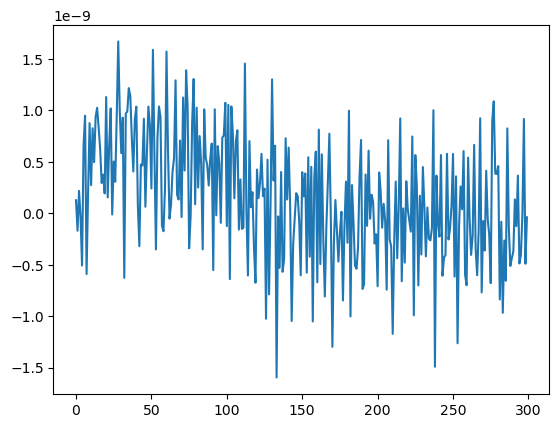

In [20]:
observed=observed_grid[:,105]
plt.plot(observed)

popt, _ = curve_fit(memory_2timescale_Charlie, time, observed, p0=p0)

popt

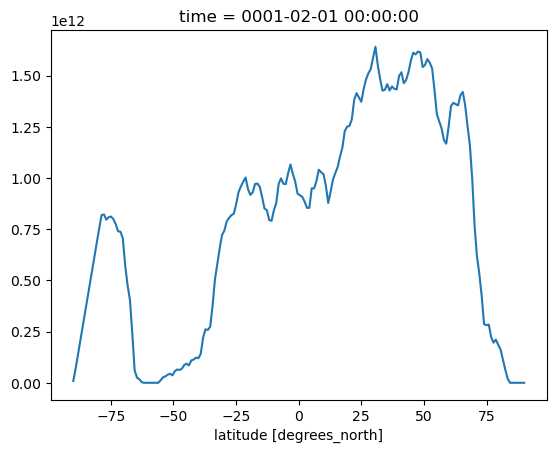

In [133]:
# param_grid_

landarea.sum(dim='lon').plot()

4.2408376


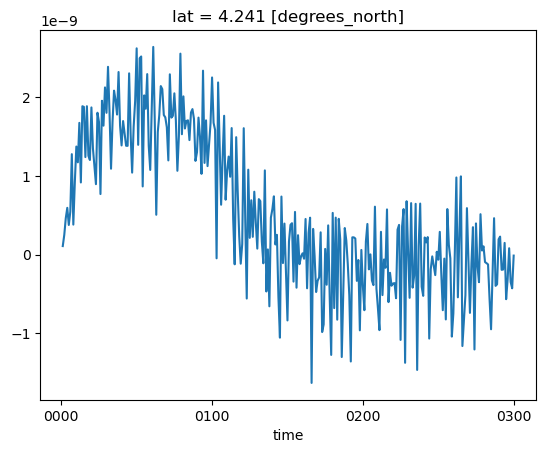

In [107]:
observed = observed_grid[:, 100]
print(ds_PgC.lat[100].values)
observed.plot()

In [113]:
# Define a local wrapper with emissions fixed
# def model_to_fit(t, tau1, tau2, sens1, sens2):
#     return memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2)

# try:
#     popt, _ = curve_fit(model_to_fit, time, observed, p0=p0, bounds=bounds)
#     # param_grid[i, :] = popt
# except Exception as e:
#     print(f"Fit failed at grid point ({i}): {e}")

popt, _ = curve_fit(model_to_fit, time, observed, p0=p0)

popt

array([6.91216109e-01, 1.38742331e+01, 5.99501766e-12, 1.19691621e-11])

In [112]:
# fit using curve_fit and Charlie's model
params_combined_2timescale, fit_combined_2timescale = scipy.optimize.curve_fit(memory_2timescale_Charlie,emissions, observed,p0) 

tau1, tau2,  sens1, sens2 = params_combined_2timescale
#sens2=1-(sens1)                                                               
# pred_landsink_Charlie = memory_2timescale_Charlie(emiss, 
#                                tau1, 
#                                tau2,
#                                sens1,
#                                sens2)

print(params_combined_2timescale)

/glade/derecho/scratch/aswann/tmp/ipykernel_28323/1883653830.py:9: RuntimeWarning: overflow encountered in exp
  r = r + emissions[tt] * (sens1 * np.exp(-(t-tt)/tau1) + sens2 * np.exp(-(t-tt)/tau2))
/glade/derecho/scratch/aswann/tmp/ipykernel_28323/1883653830.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  r = r + emissions[tt] * (sens1 * np.exp(-(t-tt)/tau1) + sens2 * np.exp(-(t-tt)/tau2))


[3.52066686e-01 1.40085810e+01 3.48132756e-10 1.17107091e-11]


In [26]:
ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
# ds0=ds.mean(dim='lon') # zonal mean
dsw=weighted_temporal_mean(ds0,var) # annual mean    
dst= select_time_slice(dsw, 0, 99) # first 100 years of flat10
# dst_PgC = unitconvert*(dst*landarea) # converted to PgC
dst_0 = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


loading variable: nbp
finished loading CESM2 *lat10 nbp


In [43]:
area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=.05)

In [49]:
# ds0g.nbp.mean(dim='time').plot()
arg=(ds_area['areacella']*ds_landfrac['sftlf'])


In [53]:
modellist

['ACCESS-ESM1-5',
 'CESM2',
 'GFDL-ESM4',
 'GISS_E2.1',
 'NorESM2-LM',
 'MPI-ESM1-2-LR',
 'CNRM-ESM2-1',
 'HadCM3LC-Bris',
 'UKESM1.2']

In [51]:
arg.lat

<xarray.DataArray 'lat' (lat: 145)> Size: 1kB
array([-90.  , -88.75, -87.5 , -86.25, -85.  , -83.75, -82.5 , -81.25, -80.  ,
       -78.75, -77.5 , -76.25, -75.  , -73.75, -72.5 , -71.25, -70.  , -68.75,
       -67.5 , -66.25, -65.  , -63.75, -62.5 , -61.25, -60.  , -58.75, -57.5 ,
       -56.25, -55.  , -53.75, -52.5 , -51.25, -50.  , -48.75, -47.5 , -46.25,
       -45.  , -43.75, -42.5 , -41.25, -40.  , -38.75, -37.5 , -36.25, -35.  ,
       -33.75, -32.5 , -31.25, -30.  , -28.75, -27.5 , -26.25, -25.  , -23.75,
       -22.5 , -21.25, -20.  , -18.75, -17.5 , -16.25, -15.  , -13.75, -12.5 ,
       -11.25, -10.  ,  -8.75,  -7.5 ,  -6.25,  -5.  ,  -3.75,  -2.5 ,  -1.25,
         0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,  10.  ,
        11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,  20.  ,  21.25,
        22.5 ,  23.75,  25.  ,  26.25,  27.5 ,  28.75,  30.  ,  31.25,  32.5 ,
        33.75,  35.  ,  36.25,  37.5 ,  38.75,  40.  ,  41.25,  42.5 ,  43.75,
        45.  ,  46.25,  47.5 ,  48.75,  50.  ,  51.25,  52.5 ,  53.75,  55.  ,
        56.25,  57.5 ,  58.75,  60.  ,  61.25,  62.5 ,  63.75,  65.  ,  66.25,
        67.5 ,  68.75,  70.  ,  71.25,  72.5 ,  73.75,  75.  ,  76.25,  77.5 ,
        78.75,  80.  ,  81.25,  82.5 ,  83.75,  85.  ,  86.25,  87.5 ,  88.75,
        90.  ])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude

# Fit it for every gridcell

In [60]:
# initialize a dictionary to hold grid data
data_dict={}
data_dict = load_grid(data_dict,modellist)

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
HadCM3LC-Bris getting grid info
UKESM1.2 getting grid info


In [65]:
# # Function to fit the model across the 2D grid
# def fit_grid_2timescale(emissions, observed_grid):
#     t, m, n = observed_grid.shape
#     param_grid = np.zeros((m, n, 4))  # Store parameters (tau1, tau2, sens1, sens2)

#     #--- model fit bounds and initial guesses
#     # initial guess
#     p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, sens1, sens2
    
#     # bounds
#     bounds_lower = [0.5, 1.0, 0.0, 0.0]
#     bounds_upper = [100.0, 1000.0, 1.0,1.0]
    
#     for i in range(m):
#         for j in range(n):
#             observed = observed_grid[:,i, j]
            
#             # Fit the model for grid point (i, j)
#             try:
#                 # # Fit using curve_fit
#                 # popt, _ = curve_fit(fit_wrapper2_grid, np.arange(len(emissions)), observed,
#                 #                     bounds=(bounds_lower, bounds_upper))
                
#                 # Fit using curve_fit
#                 popt, _ = curve_fit(fit_wrapper2, np.arange(len(emissions)), observed,
#                                     p0=p0, bounds=(bounds_lower, bounds_upper))
#                 param_grid[i, j] = popt  # Store optimized parameters
#             except Exception as e:
#                 print(f"Fit failed at grid point ({i}, {j}): {e}")
#                 param_grid[i, j] = np.nan  # Mark as NaN if fitting fails

#     return param_grid



# # Wrapper function for curve_fit: emissions is fixed, other params are free
# def fit_wrapper2(t, tau1, tau2, sens1, sens2):
#     return memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2)



# # Wrapper function for fitting each point (i, j)
# def fit_wrapper2_grid(t, emissions, observed):
#     def model(t, tau1, tau2, sens1, sens2):
#         return memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2)
#     return model(t, *params)


In [11]:
def memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2):
    if not np.isfinite(tau1) or not np.isfinite(tau2):
        print(f"Bad tau values: tau1={tau1}, tau2={tau2}")
    if tau1 <= 0 or tau2 <= 0:
        print(f"Non-positive tau values: tau1={tau1}, tau2={tau2}")
    
    nt = len(emissions)
    t = np.arange(nt)
    
    kernel1 = sens1 * np.exp(-t / tau1)
    kernel2 = sens2 * np.exp(-t / tau2)
    kernel = kernel1 + kernel2

    sink = np.convolve(emissions, kernel, mode='full')[:nt]
    return sink

In [68]:
def fit_grid_2timescale(emissions, observed_grid):
    """
    Fit a 2-timescale exponential decay model to each grid point of the observed time series.

    Parameters:
        emissions (1D array): Input emissions time series (length T)
        observed_grid (3D array): Observed response (shape T x M x N)

    Returns:
        param_grid (3D array): Optimized parameters for each grid point (shape M x N x 4)
    """
    t_len, m, n = observed_grid.shape
    param_grid = np.full((m, n, 4), np.nan)  # Store parameters (tau1, tau2, sens1, sens2)

    # Initial guess and bounds for curve fitting
    p0 = [2.0, 10.0, 0.02, 0.001]
    bounds_lower = [0.5, 1.0, 0.0, 0.0]
    bounds_upper = [100.0, 1000.0, 1.0, 1.0]
    bounds = (bounds_lower, bounds_upper)

    time = np.arange(len(emissions))

    for i in range(m):
        for j in range(n):
            observed = observed_grid[:, i, j]

            # Skip if data is all NaNs
            if np.isnan(observed).all():
                continue

            # Define a local wrapper with emissions fixed
            def model_to_fit(t, tau1, tau2, sens1, sens2):
                return memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2)

            try:
                popt, _ = curve_fit(model_to_fit, time, observed, p0=p0, bounds=bounds)
                param_grid[i, j, :] = popt
            except Exception as e:
                print(f"Fit failed at grid point ({i}, {j}): {e}")

    return param_grid


In [69]:
# fit every gridcell individually
# Create a Dask client with 8 workers 

# client = Client(n_workers=8)


params_dict={}

#--- model fit bounds and initial guesses
# initial guess
p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, sens1, sens2

# bounds
bounds_lower = [0.5, 1.0, 0.0, 0.0]
bounds_upper = [100.0, 1000.0, 1.0,1.0]

# define the emissions time series
emissions=emiss_flat10zec

unitconvert=PgperKg

# loop over models
for m in range(1):#len(modellist)):
    model=modellist[m]
    print('Fitting 2 box model to: ' +model)

    mcolor=modelcolors[m]

    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'nbp')

    ###---- grid info
    lat = ds0g.lat
    lon = ds0g.lon
    
    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')

    #----###-----####----- nbp
    var='nbp'
    # flat 10 emissions phase
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    del ds0 # drop first ds grid from memory   
    dst_0= select_time_slice(dsw, 0, 99) # first 100 years of flat10
    # dst_PgC = unitconvert*(dst*landarea) # converted to PgC
    
    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    dsw=weighted_temporal_mean(ds1,var)
    del ds1 # drop full grid from memory
    dst_1= select_time_slice(dsw, 0, 200) # first 100 years of flat10
    dst=xr.concat([dst_0,dst_1],dim='time')
    ds_PgC = unitconvert*(dst*landarea)# converted to PgC
  
    #  drop some things from memory
    # del dst_0, dst

    # tau_land_map = landarea/landarea #sftlf['sftlf']/sftlf['sftlf']
    # emiss_land_map = landarea/landarea #sftlf['sftlf']/sftlf['sftlf']
    
    # params_list = []

    observed_grid=ds_PgC #[time, lat, lon]
    
    param_grid=fit_grid_2timescale(emissions, observed_grid) #fit each grid point in a loop
    

    param_grid_da= xr.DataArray(param_grid, coords={'lon': ds_PgC['lon'], 'lat': ds_PgC['lat']}, dims=['lat', 'lon'])
    
    #----save output to a dictionary----#
    print('adding ' +model +' to dict')
    param_dict[model +'_paramfit'] = param_grid_da
    

    

Fitting 2 box model to: ACCESS-ESM1-5
loading variable: nbp
finished loading ACCESS-ESM1-5 *lat10 nbp
loading variable: nbp
finished loading ACCESS-ESM1-5 *lat10 nbp
loading variable: nbp
finished loading ACCESS-ESM1-5 *zec nbp


KeyboardInterrupt: 

In [79]:
arg=np.sum(np.isnan(param_grid))

arg

111360

In [80]:
param_grid.shape

(145, 192, 4)

In [81]:
145*192*4

111360

# Try using Dask

In [8]:
# initialize a dictionary to hold grid data
data_dict={}
data_dict = load_grid(data_dict,modellist)

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
HadCM3LC-Bris getting grid info
UKESM1.2 getting grid info


In [16]:
def memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2):
    if not np.isfinite(tau1) or not np.isfinite(tau2):
        print(f"Bad tau values: tau1={tau1}, tau2={tau2}")
    if tau1 <= 0 or tau2 <= 0:
        print(f"Non-positive tau values: tau1={tau1}, tau2={tau2}")
        
    nt = len(emissions)
    t = np.arange(nt)

    kernel1 = sens1 * np.exp(-t / tau1)
    kernel2 = sens2 * np.exp(-t / tau2)
    kernel = kernel1 + kernel2

    sink = np.convolve(emissions, kernel, mode='full')[:nt]
    return sink

In [11]:
from dask.distributed import Client
from dask import delayed, compute
from dask.diagnostics import ProgressBar

# Start a local Dask cluster (uses all cores by default)
client = Client(n_workers=8)
print(client)

<Client: 'tcp://127.0.0.1:35881' processes=8 threads=8, memory=4.00 GiB>


In [10]:
# client.close()

In [17]:
# Single-point model fit
def fit_single_point(emissions, observed, time, p0, bounds):
    if np.isnan(observed).all() or np.nanstd(observed) < 1e-6:
        return np.full(4, np.nan)

    def model(t, tau1, tau2, sens1, sens2):
        if tau1 < 1e-5 or tau2 < 1e-5 or not np.isfinite(tau1) or not np.isfinite(tau2):
            return np.full_like(t, np.nan)  # force a bad fit
        return memory_2timescale_vectorized(emissions, tau1, tau2, sens1, sens2) # not nan, so fit

    try:
        popt, _ = curve_fit(model, time, observed, p0=p0, bounds=bounds)
        return popt
    except Exception:
        return np.full(4, np.nan)

In [18]:
def fit_one_grid(emissions, observed_grid_xr):
    """
    Fit one 3D grid (time, lat, lon) using Dask parallelism.

    Returns:
        xarray.DataArray with dims (lat, lon, param)
    """
    time = np.arange(len(emissions))
    p0 = [2.0, 10.0, 0.02, 0.001]
    bounds = ([0.5, 1.0, 0.0, 0.0], [100.0, 1000.0, 1.0, 1.0])

    lat = observed_grid_xr['lat']
    lon = observed_grid_xr['lon']

    tasks = []
    for i in range(len(lat)):
        for j in range(len(lon)):
            observed = observed_grid_xr[:, i, j].values
            task = delayed(fit_single_point)(emissions, observed, time, p0, bounds)
            tasks.append(task)

    results = delayed(lambda x: np.array(x).reshape(len(lat), len(lon), 4))(tasks)

    # Wrap result into xarray.DataArray (delayed for now)
    param_names = ['tau1', 'tau2', 'sens1', 'sens2']
    result_da = delayed(
        lambda arr: xr.DataArray(arr,
                                 coords={'lat': lat, 'lon': lon, 'param': param_names},
                                 dims=['lat', 'lon', 'param'])
                        )(results)

    return result_da

In [14]:
'''
# Example: list of your model names or identifiers
model_names = ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9']

# Function to load dataset for a given model
def load_dataset_for_model(model_name):
    # Replace this with your actual loading function,
    # which should return an xarray.DataArray with dims (time, lat, lon)
    # For example:
    # ds = xr.open_dataset(f"data/{model_name}_observed.nc")
    # return ds['variable_name']
    pass

# Create delayed tasks for all models
delayed_fits = []
for model in model_names:
    ds = load_dataset_for_model(model)  # Load dataset for that model
    # ds should be xarray.DataArray with dims (time, lat, lon)
    
    # Create delayed task for fitting this model's grid
    delayed_task = fit_one_grid(emissions, ds)
    delayed_fits.append(delayed_task)

# Compute all fits in parallel with a progress bar
with ProgressBar():
    results = compute(*delayed_fits)

# Store results in a dictionary keyed by model name
fit_results = {model: res for model, res in zip(model_names, results)}

# Optionally save each result
for model, da in fit_results.items():
    da.to_netcdf(f"{model}_fit.nc")
    '''

'\n# Example: list of your model names or identifiers\nmodel_names = [\'model1\', \'model2\', \'model3\', \'model4\', \'model5\', \'model6\', \'model7\', \'model8\', \'model9\']\n\n# Function to load dataset for a given model\ndef load_dataset_for_model(model_name):\n    # Replace this with your actual loading function,\n    # which should return an xarray.DataArray with dims (time, lat, lon)\n    # For example:\n    # ds = xr.open_dataset(f"data/{model_name}_observed.nc")\n    # return ds[\'variable_name\']\n    pass\n\n# Create delayed tasks for all models\ndelayed_fits = []\nfor model in model_names:\n    ds = load_dataset_for_model(model)  # Load dataset for that model\n    # ds should be xarray.DataArray with dims (time, lat, lon)\n\n    # Create delayed task for fitting this model\'s grid\n    delayed_task = fit_one_grid(emissions, ds)\n    delayed_fits.append(delayed_task)\n\n# Compute all fits in parallel with a progress bar\nwith ProgressBar():\n    results = compute(*delayed_

In [19]:
# fit every gridcell individually
# Create a Dask client with 8 workers 

# client = Client(n_workers=8)


# params_dict={}

# #--- model fit bounds and initial guesses
# # initial guess
# p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, sens1, sens2

# # bounds
# bounds_lower = [0.5, 1.0, 0.0, 0.0]
# bounds_upper = [100.0, 1000.0, 1.0,1.0]

# Function to load dataset for a given model
def load_dataset_for_model(model_name):
    # Replace this with your actual loading function,
    # which should return an xarray.DataArray with dims (time, lat, lon)
    # For example:
    # ds = xr.open_dataset(f"data/{model_name}_observed.nc")
    # return ds['variable_name']
    pass


# define the emissions time series
emissions=emiss_flat10zec

unitconvert=PgperKg

# Create delayed tasks for all models
delayed_fits = []

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Fitting 2 box model to: ' +model)

    # mcolor=modelcolors[m]

    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'nbp')

    ###---- grid info
    lat = ds0g.lat
    lon = ds0g.lon
    
    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')

    #----###-----####----- nbp
    var='nbp'
    # flat 10 emissions phase
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    del ds0 # drop first ds grid from memory   
    dst_0= select_time_slice(dsw, 0, 99) # first 100 years of flat10
    # dst_PgC = unitconvert*(dst*landarea) # converted to PgC
    
    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    dsw=weighted_temporal_mean(ds1,var)
    del ds1 # drop full grid from memory
    dst_1= select_time_slice(dsw, 0, 200) # first 100 years of flat10
    dst=xr.concat([dst_0,dst_1],dim='time')
    ds_PgC = unitconvert*(dst*landarea)# converted to PgC
  
    #  drop some things from memory
    # del dst_0, dst

    # tau_land_map = landarea/landarea #sftlf['sftlf']/sftlf['sftlf']
    # emiss_land_map = landarea/landarea #sftlf['sftlf']/sftlf['sftlf']
    
    # params_list = []

    # observed_grid=ds_PgC #[time, lat, lon]

    # Create delayed task for fitting this model's grid
    delayed_task = fit_one_grid(emissions, ds_PgC)
    delayed_fits.append(delayed_task)


    
    # param_grid=fit_grid_2timescale(emissions, observed_grid) #fit each grid point in a loop
    

    # param_grid_da= xr.DataArray(param_grid, coords={'lon': ds_PgC['lon'], 'lat': ds_PgC['lat']}, dims=['lat', 'lon'])
    
    # #----save output to a dictionary----#
    # print('adding ' +model +' to dict')
    # param_dict[model +'_paramfit'] = param_grid_da
    
# Compute all fits in parallel with a progress bar
with ProgressBar():
    results = compute(*delayed_fits)

# Store results in a dictionary keyed by model name
fit_results = {model: res for model, res in zip(modellist, results)}

# Optionally save each result
for model, da in fit_results.items():
    da.to_netcdf(f"{model}_fit2box.nc")
    

Fitting 2 box model to: ACCESS-ESM1-5
loading variable: nbp
finished loading ACCESS-ESM1-5 *lat10 nbp
loading variable: nbp
finished loading ACCESS-ESM1-5 *lat10 nbp
loading variable: nbp
finished loading ACCESS-ESM1-5 *zec nbp


KeyboardInterrupt: 

In [20]:
client.close()

TimeoutError: timed out after 60 s.

In [ ]:
# Function to fit a single point (i, j) in the grid
@delayed
def fit_one_point_2timescale(i, j, emissions, observed_grid):
    observed = observed_grid[i, :]

    # bounds
    bounds_lower = [0.5, 1.0, 0.0, 0.0]
    bounds_upper = [100.0, 1000.0, 1.0,1.0]
    
    try:
        # Fit using curve_fit
        popt, _ = curve_fit(fit_wrapper, np.arange(len(emissions)), observed,
                            bounds=(bounds_lower, bounds_upper))
        return popt
    except Exception as e:
        print(f"Fit failed at grid point ({i}, {j}): {e}")
        return np.nan

# Function to fit the model across the entire 2D grid using Dask
def fit_grid_2timescale_dask(emissions, observed_grid):
    t, m , n = observed_grid.shape
    
    # Create a list of delayed tasks for each grid point
    delayed_results = []
    for i in range(m):
        for j in range(n):
            delayed_results.append(fit_one_point_2timescale(i, j, emissions, observed_grid))
    
    # Compute the results in parallel using Dask
    results = compute(*delayed_results)
    
    # Reshape the result into (m, n, 4) to store the parameters (tau1, tau2, sens1, sens2)
    param_grid = np.array(results).reshape(m, n, 4)
    
    return param_grid

In [21]:
#Charlie's version
def my_function(func, x, y, params_in, i, j):
    try:
        params, fit = curve_fit(func, x, y, params_in)
    except:
        params = [np.nan, np.nan,np.nan,np.nan]
    return [i,j, params[0], params[1],params[2],params[3]]



In [ ]:
'''# code from Charlie
tau_land_map = sftlf['sftlf']/sftlf['sftlf']
emiss_land_map = sftlf['sftlf']/sftlf['sftlf']

params_list = []
#for i in range(30,31):
for i in range(len(tau_land_map['lon'])):
    for j in range(len(tau_land_map['lat'])):
        if tau_land_map.isel(lat=j,lon=i) == 1.:

                params_out = client.submit(my_function, memory, emiss[100:], nbp_annual.isel(lat=j,lon=i), [12., 1e-9], i, j)
                params_list.append(params_out)
    #print('finished lon',i)
#tau_land_map.plot()
results = client.gather(params_list)
client.close()'''

In [ ]:
# fit every gridcell individually
# Create a Dask client with 8 workers 

client = Client(n_workers=8)


params_list = []

#--- model fit bounds and initial guesses
# initial guess
p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, tau3, sens1, sens2

# bounds
bounds_lower = [0.5, 1.0, 0.0, 0.0]
bounds_upper = [100.0, 1000.0, 1.0,1.0]

# define the emissions time series
emissions=emiss_flat10zec

unitconvert=PgperKg

# loop over models
for m in range(1):#len(modellist)):
    model=modellist[m]
    print('Fitting 2 box model to: ' +model)

    mcolor=modelcolors[m]

    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'nbp')

    ###---- grid info
    lat = ds0g.lat
    lon = ds0g.lon
    
    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')

    #----###-----####----- nbp
    var='nbp'
    # flat 10 emissions phase
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    del ds0 # drop first ds grid from memory   
    dst_0= select_time_slice(dsw, 0, 99) # first 100 years of flat10
    # dst_PgC = unitconvert*(dst*landarea) # converted to PgC
    
    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    dsw=weighted_temporal_mean(ds1,var)
    del ds1 # drop full grid from memory
    dst_1= select_time_slice(dsw, 0, 200) # first 100 years of flat10
    dst=xr.concat([dst_0,dst_1],dim='time')
    ds_PgC = unitconvert*(dst*landarea)# converted to PgC
  
    #  drop some things from memory
    # del dst_0, dst

    tau_land_map = landarea/landarea #sftlf['sftlf']/sftlf['sftlf']
    emiss_land_map = landarea/landarea #sftlf['sftlf']/sftlf['sftlf']
    
    params_list = []
    #for i in range(30,31):
    for i in range(len(tau_land_map['lon'])):
        for j in range(len(tau_land_map['lat'])):
            if tau_land_map.isel(lat=j,lon=i) == 1.:
                    params_out = client.submit(my_function, memory_2timescale_vectorized, emissions, ds_PgC.isel(lat=j,lon=i), p0, i, j)
                    params_list.append(params_out)
        #print('finished lon',i)
    #tau_land_map.plot()
    results = client.gather(params_list)


    # param_grid = np.zeros((m, len(lat),len(lon), 4)) #store parameters
    
    # # loop over all lat and lon
    # for lt in range(len(lat)):
    #     for ln in range(len(lon)):
    #         sink_obs=ds_PgC[:,lt,ln].values
    #         emiss=emissions[0:(len(sink_obs)+1)]

    #         # IRF model fit
    #         try:
    #             popt, _ = curve_fit(fit_wrapper2, np.arange(len(emiss)), sink_obs,
    #                                    bounds=(bounds_lower, bounds_upper))
    #             param_grid[lt, ln] = popt  # Store the optimized parameters
    #         except Exception as e:
    #             print(f"Fit failed at grid point ({lt}, {ln}): {e}")
    #             param_grid[lt, ln] = np.nan  # Mark as NaN if fitting fails
            
            # tau1, tau2, sens1, sens2 = popt
            # box_model_pred_2=fit_wrapper2(np.arange(len(emiss)),tau1,tau2,sens1,sens2)

            # tau1_mat[lt,ln]=tau1
            # tau2_mat[lt,ln]=tau2
            # sens1_mat[lt,ln]=sens1
            # sens2_mat[lt,ln]=sens2
            
            # params_list.append(popt) 

client.close()

Fitting 2 box model to: ACCESS-ESM1-5
loading variable: nbp
finished loading ACCESS-ESM1-5 *lat10 nbp
loading variable: nbp
finished loading ACCESS-ESM1-5 *lat10 nbp
loading variable: nbp
finished loading ACCESS-ESM1-5 *zec nbp


/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid

In [26]:
client.close()

NameError: name 'client' is not defined

In [ ]:
# initialize some empty arrays to store outputs
tau1_vec=np.empty(len(modellist))
tau2_vec=np.empty(len(modellist))
sens1_vec=np.empty(len(modellist))
sens2_vec=np.empty(len(modellist))


# define the emissions time series
emiss=emiss_flat10zec
emissions=emiss

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output
  
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    sink_obs=NBP

    #--- model fit
    # initial guess
    p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, tau3, sens1, sens2

    # bounds
    bounds_lower = [0.5, 1.0, 0.0, 0.0]
    bounds_upper = [100.0, 1000.0, 1.0,1.0]


    # fit using curve_fit and Charlie's model
    # params_combined_2timescale, fit_combined_2timescale = scipy.optimize.curve_fit(memory_2timescale_Charlie,emiss, sink_obs,p0) 

    # tau1, tau2,  sens1, sens2 = params_combined_2timescale
    # #sens2=1-(sens1)                                                               
    # pred_landsink_Charlie = memory_2timescale_Charlie(emiss, 
    #                                tau1, 
    #                                tau2,
    #                                sens1,
    #                                sens2)

    # Example data
    # emissions: your input time series (1D np.array)
    # observed: the corresponding observed response (same shape)
    
    popt, pcov = curve_fit(fit_wrapper2, np.arange(len(emiss)), sink_obs,
                           bounds=(bounds_lower, bounds_upper))

    tau1, tau2,  sens1, sens2 = popt
    box_model_pred_2=fit_wrapper2(np.arange(len(emiss)),tau1,tau2,sens1,sens2)

    # # Extract parameters
    # tau1, tau2,  sens1 = popt
    # sens2=1-(sens1)
    print(f"taus: {tau1:.2f}, {tau2:.2f}")
    print(f"sensitivities: {sens1:.3f}, {sens2:.3f}")
    
    
    # pred_totalsink_2timescale_zec = memory_model_2timescale_constrained_safe(emiss, 
    #                                                   tau1, 
    #                                                   tau2,  
    #                                                   sens1
    #                                                  )

    plt.figure(figsize=(4, 3))    
    plt.plot(emiss, color='blue')
    plt.plot(sink_obs, color='green',label='ESM land sink')
    plt.plot(box_model_pred_2, color='black',label='2 box model land sink')
    
    # plt.plot(pred_landsink_Charlie, color='purple',label='Charlies version',linestyle='--')
    # plt.title('Carbon Fluxes, flat10-zec')
    plt.title(model +' Optimized Parameters 2tau' )
    plt.ylabel('Pg C')
    plt.xlabel('time')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


    tau1_vec[m]=tau1
    tau2_vec[m]=tau2
    sens1_vec[m]=sens1
    sens2_vec[m]=sens2
    
# #-- add output to a pandas data frame
esm_boxfit = pd.DataFrame({})
esm_boxfit['tau1']=tau1_vec
esm_boxfit['tau2']=tau2_vec
esm_boxfit['sens1']=sens1_vec
esm_boxfit['sens2']=sens2_vec

esm_boxfit.index=modellist

esm_boxfit_global_zec=esm_boxfit

In [ ]:
   
    ###----------------------Plot-------------------------###
    # plt.plot(ds_PgC.sum(dim=['lat','lon']))
    # plt.title(model)
    # to use, refer to one index in axs: ax = axs[row, column]


#     #--------------------------Second row is total carbon units (PgC)
#     #---First column is flat10 climatology
#     #--- first figure is the climatology, or average of first 10 years 
#     ax = axes0[m]


#     # plot lines soil, veg + soil, total-litter, total
# #    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
# #    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
# #    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
#     #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

#     ax.plot(dsften_cTot_PgC,lat, linestyle='-',color=mcolor,label='Total C')
#     ax.plot(dsften_cSoil_PgC,lat, linestyle='--',color=mcolor,label='_nolabel_')
#     ax.plot((dsften_cVeg_PgC+dsften_cSoil_PgC),lat, linestyle='-.',color=mcolor,label='_nolabel_')

#     # plot shaded area
#     # soil, soil to veg
#     #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
#     fg = ax.fill_betweenx(lat,0, dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
#     fg2 = ax.fill_betweenx(lat,dsften_cSoil_PgC,dsften_cSoil_PgC+dsften_cVeg_PgC,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

#     ax.set_ylim([-90, 90])
#     ax.grid(True,alpha=0.2, zorder=0)
#     ax.set_ylabel('')
#     ax.set_title(model)
#     if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
#         ax.set_yticklabels([])
    
#     ax.set_xlim([0, 100])

#     if m>num_cols-1:
#         ax.set_xlabel('[PgC]')
    
#     #--- Second figure is end of flat10 emissions phase
#     ax = axes1[m]
#     #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
#     #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)
    

#     # plot lines soil, veg + soil, total-litter, total
#     (dslten0_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
#     (dslten0_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#     ((dslten0_cVeg_PgC+dslten0_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
#     #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

#     # plot shaded area
#     # soil, soil to veg
#     #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
#     fg = ax.fill_betweenx(lat,0, dslten0_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
#     fg2 = ax.fill_betweenx(lat,dslten0_cSoil_PgC-dsften_cSoil_PgC,(dslten0_cSoil_PgC-dsften_cSoil_PgC)+(dslten0_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

#     ax.set_ylim([-90, 90])
#     ax.grid(True,alpha=0.2, zorder=0)
#     ax.set_ylabel('')
#     ax.set_title(model)
#     if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
#         ax.set_yticklabels([])

#     ax.set_xlim([-1, 14])

#     if m>num_cols-1:
#         ax.set_xlabel('[PgC]')

#     #--- Third figure is end of flat10zec phase
#     ax = axes2[m] 
#     #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
#     #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

#     # plot lines soil, veg + soil, total-litter, total
#     (dslten1_cTot_PgC-dslten0_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
#     (dslten1_cSoil_PgC-dslten0_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#     ((dslten1_cVeg_PgC+dslten1_cSoil_PgC)-(dslten0_cVeg_PgC+dslten0_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
#     #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

#     # plot shaded area
#     # soil, soil to veg
#     #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
#     fg = ax.fill_betweenx(lat,0, dslten1_cSoil_PgC-dslten0_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
#     fg2 = ax.fill_betweenx(lat,dslten1_cSoil_PgC-dslten0_cSoil_PgC,(dslten1_cSoil_PgC-dslten0_cSoil_PgC)+(dslten1_cVeg_PgC-dslten0_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

#     ax.set_ylim([-90, 90])
#     ax.grid(True,alpha=0.2, zorder=0)
#     ax.set_ylabel('')
#     ax.set_title(model)
#     if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
#         ax.set_yticklabels([])

#     ax.set_xlim([-4, 6])

#     if m>num_cols-1:
#         ax.set_xlabel('[PgC]')
        
#     #--- Fourth figure is end of flat10cdr phase

#     ax = axes3[m] 

#     #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
#     #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


#     # plot lines soil, veg + soil, total-litter, total
#     (dslten2_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
#     (dslten2_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#     ((dslten2_cVeg_PgC+dslten2_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
#     #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
#     # plot shaded area
#     # soil, soil to veg
#     #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
#     fg = ax.fill_betweenx(lat,0, dslten2_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
#     fg2 = ax.fill_betweenx(lat,dslten2_cSoil_PgC-dsften_cSoil_PgC,(dslten2_cSoil_PgC-dsften_cSoil_PgC)+(dslten2_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

#     ax.set_ylim([-90, 90])
#     ax.grid(True,alpha=0.2, zorder=0)
#     ax.set_ylabel('')
#     ax.set_title(model)
#     if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
#         ax.set_yticklabels([])
    
#     ax.set_xlim([-4, 6])

#     if m>num_cols-2:
#         ax.set_xlabel('[PgC]')
    

# # add gridlines
# #axes0[m].grid(True,alpha=0.2, zorder=0)

# # add legend
# axes0[0].legend(loc='lower right')
# axes1[0].legend(loc='lower right')
# axes2[0].legend(loc='lower right')
# axes3[0].legend(loc='lower right')

# # remve the empty plot in the last slot - if we add a 10th model will need to disable this!
# axes0[9].set_visible(False) 
# axes1[9].set_visible(False)
# axes2[9].set_visible(False) 
# axes3[9].set_visible(False)

# # set title over whole plot
# fig0.suptitle('Initial Carbon Stocks (beginning of flat10)')
# fig1.suptitle('Carbon gained during emissions phase (end of flat10 - beginning of flat10)')
# fig2.suptitle('Carbon change after net-zero (end of flat10zec - end of flat10)')
# fig3.suptitle('Carbon change at cumulative zero emissions (end of flat10cdr - beginning of flat10)')

# # save the plot
# fig0.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[0] +'.png', bbox_inches='tight', dpi=400)
# plt.show(fig0)
# plt.close(fig0)

# fig1.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[1] +'.png', bbox_inches='tight', dpi=400)
# plt.show(fig1)
# plt.close(fig1)

# fig2.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[2] +'.png', bbox_inches='tight', dpi=400)
# plt.show(fig2)
# plt.close(fig2)

# fig3.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[3] +'.png', bbox_inches='tight', dpi=400)
# plt.show(fig3)
# plt.close(fig3)

# print('done saving file')

# # close the plot (so python stops trying to hold on to it in memory; you can
# # still look at it at this point, but you're done editing)
# # plt.close()

# big mess below here!

estimating parameters for model: CESM2
[2.18985439e+00 2.74234563e+01 5.45360794e-02 1.01032309e-02]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7408e+05                                    4.13e+05    
       1              2         6.8027e+04      2.06e+05       3.47e+00       7.94e+04    
       2              3         1.9845e+04      4.82e+04       2.40e+00       1.46e+04    
       3              4         7.7359e+03      1.21e+04       1.68e+00       2.43e+03    
       4              5         4.5632e+03      3.17e+03       1.10e+00       4.71e+02    
       5              6         3.9014e+03      6.62e+02       4.55e-01       3.98e+01    
       6              7         3.8490e+03      5.24e+01       4.78e-02       2.89e-01    
       7              8         3.8486e+03      3.78e-01       3.57e-04       1.51e-05    
       8              9         3.8486e+03      2.18e-06       5.26e+01       2.

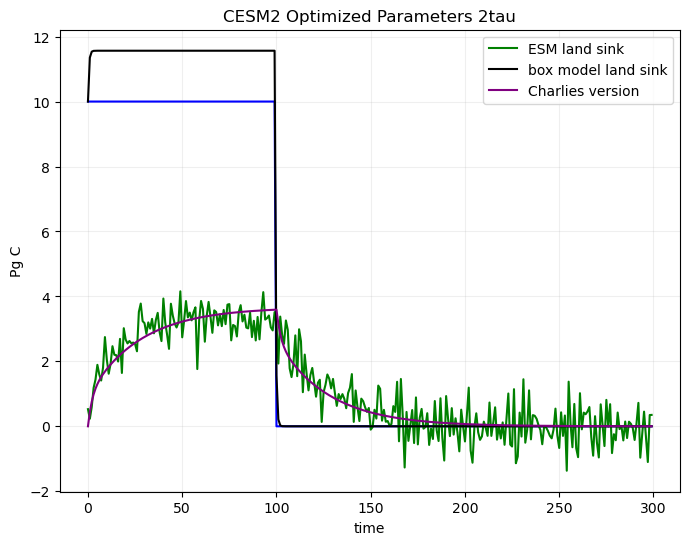

estimating parameters for model: GFDL-ESM4
[3.44969368e+00 2.29788267e+01 2.39195120e-02 1.26008956e-02]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7432e+05                                    4.13e+05    
       1              2         6.8132e+04      2.06e+05       3.47e+00       7.94e+04    
       2              3         1.9910e+04      4.82e+04       2.40e+00       1.46e+04    
       3              4         7.7851e+03      1.21e+04       1.68e+00       2.42e+03    
       4              5         4.6079e+03      3.18e+03       1.10e+00       4.71e+02    
       5              6         3.9469e+03      6.61e+02       4.53e-01       3.94e+01    
       6              7         3.8949e+03      5.19e+01       4.72e-02       2.80e-01    
       7              8         3.8946e+03      3.67e-01       3.46e-04       1.41e-05    
       8              9         3.8946e+03      1.85e-05       1.75e-08     

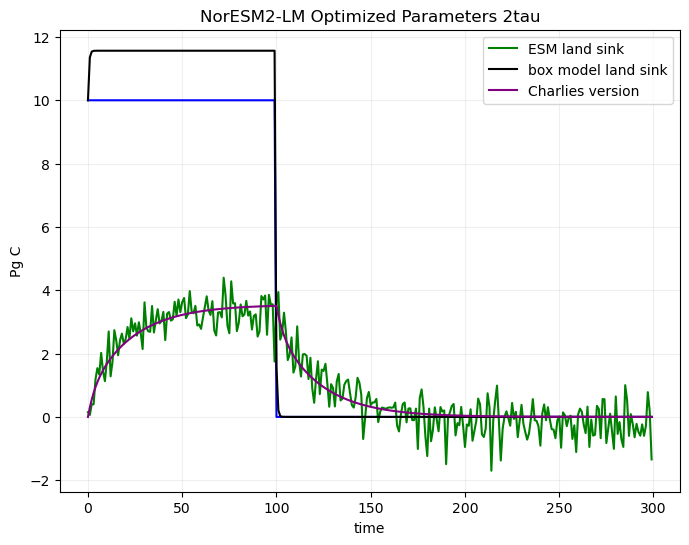

estimating parameters for model: MPI-ESM1-2-LR
[7.44486729e+00 8.54280521e+01 4.18306210e-02 1.25580528e-03]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7295e+05                                    4.13e+05    
       1              2         6.7626e+04      2.05e+05       3.47e+00       7.93e+04    
       2              3         1.9747e+04      4.79e+04       2.39e+00       1.45e+04    
       3              4         7.7550e+03      1.20e+04       1.67e+00       2.43e+03    
       4              5         4.6109e+03      3.14e+03       1.10e+00       4.77e+02    
       5              6         3.9431e+03      6.68e+02       4.64e-01       4.24e+01    
       6              7         3.8872e+03      5.59e+01       5.20e-02       3.47e-01    
       7              8         3.8868e+03      4.54e-01       4.38e-04       2.31e-05    
       8              9         3.8868e+03      1.31e-05       5.26e+01 

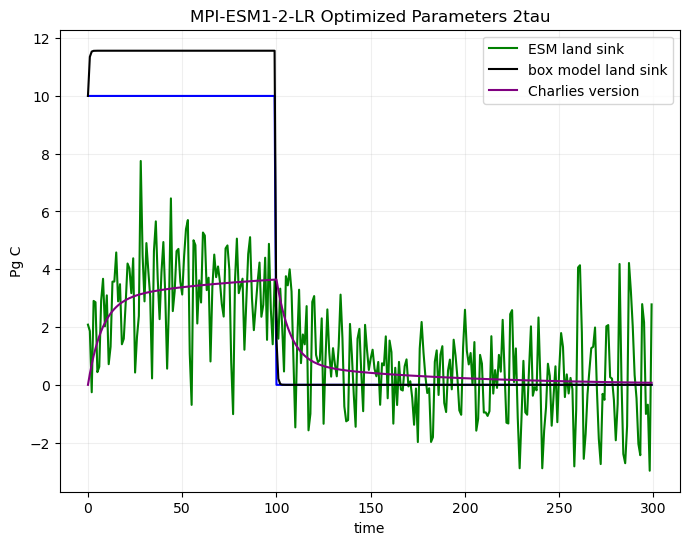

estimating parameters for model: CNRM-ESM2-1
[ 1.56530445e+01  1.56785206e+01 -2.45868853e-03  2.65754483e-02]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7263e+05                                    4.12e+05    
       1              2         6.7506e+04      2.05e+05       3.47e+00       7.92e+04    
       2              3         1.9631e+04      4.79e+04       2.39e+00       1.46e+04    
       3              4         7.6224e+03      1.20e+04       1.67e+00       2.44e+03    
       4              5         4.4696e+03      3.15e+03       1.10e+00       4.77e+02    
       5              6         3.8001e+03      6.69e+02       4.66e-01       4.23e+01    
       6              7         3.7442e+03      5.59e+01       5.21e-02       3.44e-01    
       7              8         3.7438e+03      4.50e-01       4.36e-04       2.25e-05    
       8              9         3.7438e+03      1.24e-05       5.26e+0

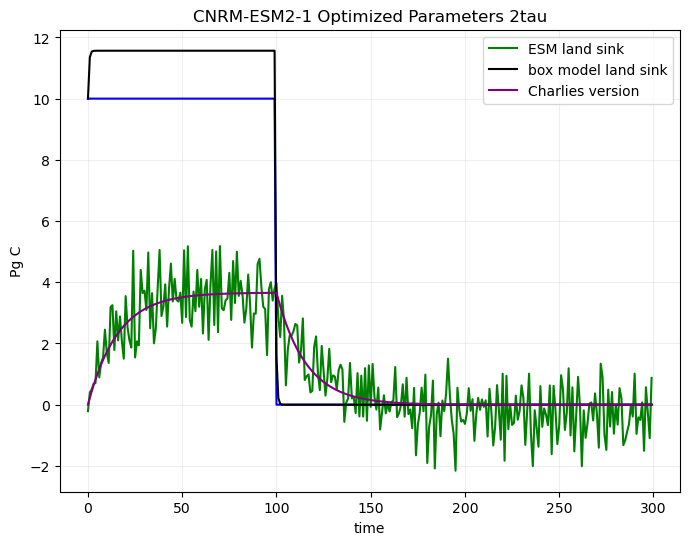

estimating parameters for model: HadCM3LC-Bris
[6.61467956 6.61467195 0.032505   0.02258384]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7349e+05                                    4.14e+05    
       1              2         6.7727e+04      2.06e+05       3.48e+00       7.93e+04    
       2              3         1.9837e+04      4.79e+04       2.40e+00       1.45e+04    
       3              4         7.8620e+03      1.20e+04       1.67e+00       2.41e+03    
       4              5         4.7259e+03      3.14e+03       1.09e+00       4.77e+02    
       5              6         4.0604e+03      6.66e+02       4.61e-01       4.22e+01    
       6              7         4.0048e+03      5.56e+01       5.13e-02       3.44e-01    
       7              8         4.0044e+03      4.49e-01       4.30e-04       2.26e-05    
       8              9         4.0044e+03      1.22e-05       5.26e+01       2.59e-11  

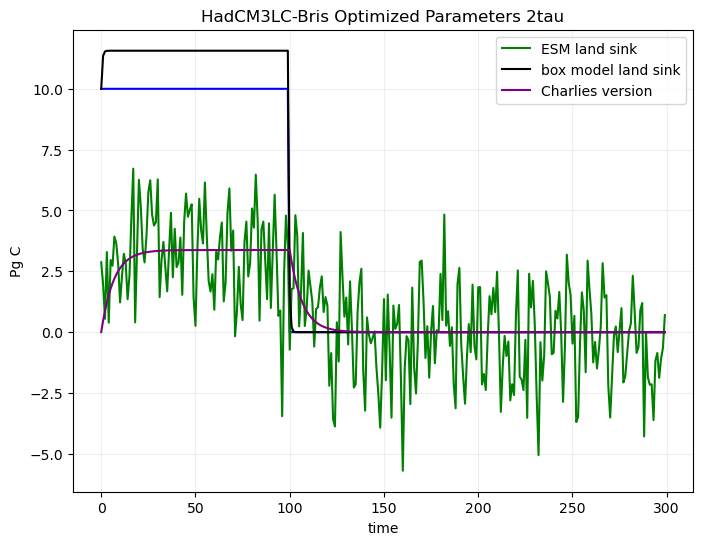

In [104]:
latrange='global'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year

# initialize some empty arrays to store outputs
tau1_vec=np.empty(len(modellist))
tau2_vec=np.empty(len(modellist))
sens1_vec=np.empty(len(modellist))
sens2_vec=np.empty(len(modellist))


# define the emissions time series
emiss=emiss_flat10zec

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output
  
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    sink_obs=NBP

    #--- model fit
    # initial guess
    p0 = [2.0, 10.0,  0.3]  # tau1, tau2, tau3, sens1, sens2

    # bounds
    bounds_lower = [0.5, 1.0, 0.0]
    bounds_upper = [100.0, 200.0, 1.0]

    # # fit model using curve_fit
    # popt, pcov = curve_fit(memory_model_3timescale_constrained_safe,
    #                        emiss, sink_obs,
    #                        p0=p0, bounds=(bounds_lower, bounds_upper))

    # fit using curve_fit and Charlie's model
    params_combined_2timescale, fit_combined_2timescale = scipy.optimize.curve_fit(memory_2timescale_Charlie, 
                                                                              emiss, 
                                                                                   sink_obs, 
                                                                                   p0)
    print(params_combined_2timescale)
    pred_landsink_Charlie = memory_2timescale_Charlie(emiss, 
                                   params_combined_2timescale[0], 
                                   params_combined_2timescale[1],
                                   params_combined_2timescale[2],
                                   params_combined_2timescale[3])

    # Fit using least_squares
    res = least_squares(residuals_2timescale,
                        x0=p0,
                        bounds=(bounds_lower, bounds_upper),
                        args=(emiss, sink_obs),
                        verbose=2)  # show progress
    
    popt = res.x



    # Extract parameters
    tau1, tau2,  sens1 = popt
    sens2=1-(sens1)
    print(f"taus: {tau1:.2f}, {tau2:.2f}")
    print(f"sensitivities: {sens1:.3f}, {sens2:.3f}")
    
    
    pred_totalsink_2timescale_zec = memory_model_2timescale_constrained_safe(emiss, 
                                                      tau1, 
                                                      tau2,  
                                                      sens1
                                                     )

    plt.figure(figsize=(8, 6))    
    plt.plot(emiss, color='blue')
    plt.plot(sink_obs, color='green',label='ESM land sink')
    plt.plot(pred_totalsink_2timescale_zec, color='black',label='box model land sink')
    
    plt.plot(pred_landsink_Charlie, color='purple',label='Charlies version')
    # plt.title('Carbon Fluxes, flat10-zec')
    plt.title(model +' Optimized Parameters 2tau' )
    plt.ylabel('Pg C')
    plt.xlabel('time')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


    # tau1_vec[m]=tau1
    # tau2_vec[m]=tau2
    # tau3_vec[m]=tau3
    # a1_vec[m]=sens1
    # a2_vec[m]=sens2
    # a3_vec[m]=sens3
    
# # #-- add output to a pandas data frame
# esm_boxfit = pd.DataFrame({})
# esm_boxfit['fV']=fV_vec
# esm_boxfit['fL']=fL_vec
# esm_boxfit['fS']=fS_vec
# esm_boxfit['Q10']=Q10_vec

# esm_boxfit.index=modellist

# esm_boxfit_global_zec=esm_boxfit

In [96]:
latrange='global'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year

# initialize some empty arrays to store outputs
tau1_vec=np.empty(len(modellist))
tau2_vec=np.empty(len(modellist))
tau3_vec=np.empty(len(modellist))
a1_vec=np.empty(len(modellist))
a2_vec=np.empty(len(modellist))
a3_vec=np.empty(len(modellist))

# define the emissions time series
emiss=emiss_flat10zec

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output
  
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    sink_obs=NBP

    #--- model fit
    # initial guess
    p0 = [2.0, 10.0, 100.0, 0.3, 0.3]  # tau1, tau2, tau3, sens1, sens2

    # bounds
    bounds_lower = [0.5, 1.0, 5.0, 0.0, 0.0]
    bounds_upper = [100.0, 200.0, 1000.0, 1.0, 1.0]

    # # fit model using curve_fit
    # popt, pcov = curve_fit(memory_model_3timescale_constrained_safe,
    #                        emiss, sink_obs,
    #                        p0=p0, bounds=(bounds_lower, bounds_upper))

    # fit using curve_fit and Charlie's model
    params_combined_3timescale, fit_combined_3timescale = scipy.optimize.curve_fit(memory_3timescale_Charlie, 
                                                                                   emiss, 
                                                                                   sink_obs, 
                                                                                   [10.,10., 100., 0.02, 0.01,0.001])
    print(params_combined_3timescale)
    pred_landsink_Charlie = memory_3timescale_Charlie(emiss, 
                                   params_combined_3timescale[0], 
                                   params_combined_3timescale[1],
                                   params_combined_3timescale[2],
                                   params_combined_3timescale[3], 
                                   params_combined_3timescale[4], 
                                   params_combined_3timescale[5])

    # Fit using least_squares
    res = least_squares(residuals_3timescale,
                        x0=p0,
                        bounds=(bounds_lower, bounds_upper),
                        args=(emiss, sink_obs),
                        verbose=2)  # show progress
    
    popt = res.x



    # Extract parameters
    tau1, tau2, tau3, sens1, sens2 = popt
    sens3=1-(sens1+sens2)
    print(f"taus: {tau1:.2f}, {tau2:.2f}, {tau3:.2f}")
    print(f"sensitivities: {sens1:.3f}, {sens2:.3f}, {sens3:.3f}")
    
    
    pred_totalsink_3timescale_zec = memory_model_3timescale_constrained_safe(emiss, 
                                                      tau1, 
                                                      tau2, 
                                                      tau3, 
                                                      sens1, 
                                                      sens2
                                                     )

    plt.figure(figsize=(8, 6))    
    plt.plot(emiss, color='blue')
    plt.plot(sink_obs, color='green',label='ESM land sink')
    plt.plot(pred_totalsink_3timescale_zec, color='black',label='box model land sink')
    
    plt.plot(fit_combined_3timescale, color='purple',label='Charlies version')
    # plt.title('Carbon Fluxes, flat10-zec')
    plt.title(model +' Optimized Parameters 3tau' )
    plt.ylabel('Pg C')
    plt.xlabel('time')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


    tau1_vec[m]=tau1
    tau2_vec[m]=tau2
    tau3_vec[m]=tau3
    a1_vec[m]=sens1
    a2_vec[m]=sens2
    a3_vec[m]=sens3
    
# # #-- add output to a pandas data frame
# esm_boxfit = pd.DataFrame({})
# esm_boxfit['fV']=fV_vec
# esm_boxfit['fL']=fL_vec
# esm_boxfit['fS']=fS_vec
# esm_boxfit['Q10']=Q10_vec

# esm_boxfit.index=modellist

# esm_boxfit_global_zec=esm_boxfit

estimating parameters for model: ACCESS-ESM1-5


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

estimating parameters for model: ACCESS-ESM1-5
taus: 1.44, 7.05, 86.15
sensitivities: 0.507, 0.493, 0.000


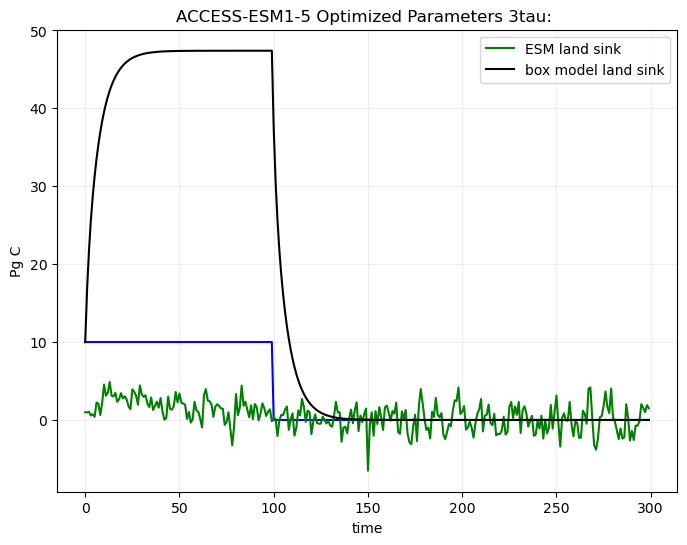

estimating parameters for model: CESM2
taus: 1.44, 7.07, 86.15
sensitivities: 0.507, 0.493, 0.000


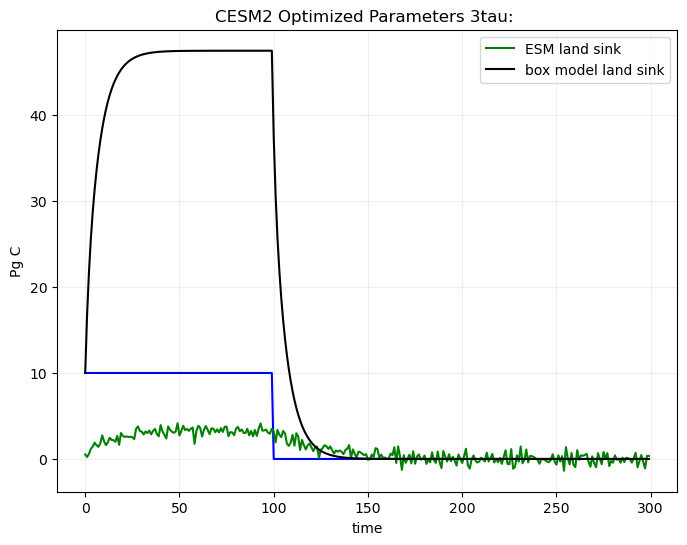

estimating parameters for model: GFDL-ESM4
taus: 1.44, 7.06, 86.14
sensitivities: 0.507, 0.493, 0.000


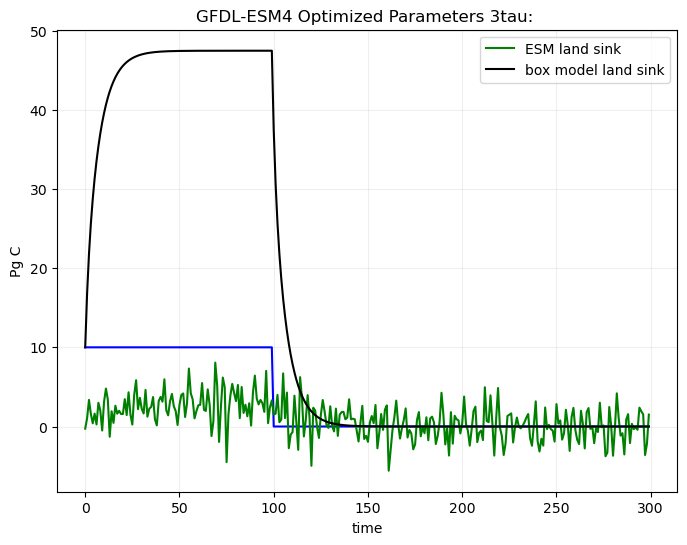

estimating parameters for model: GISS_E2.1
taus: 1.43, 7.04, 86.16
sensitivities: 0.507, 0.493, 0.000


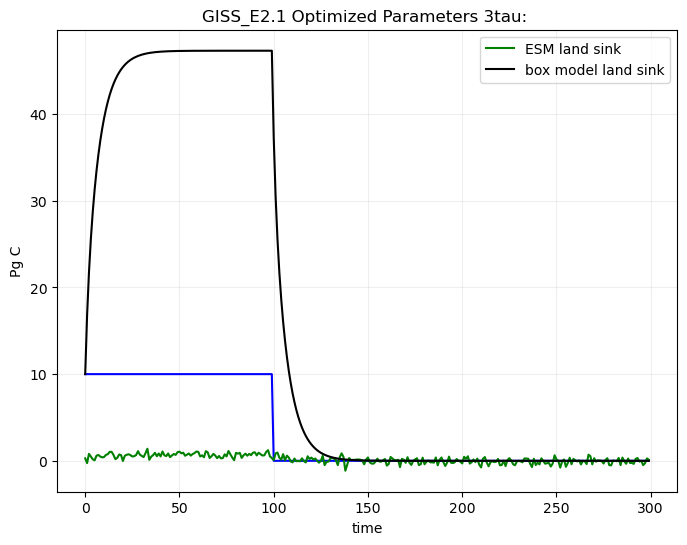

estimating parameters for model: NorESM2-LM
taus: 1.44, 7.07, 86.12
sensitivities: 0.507, 0.493, 0.000


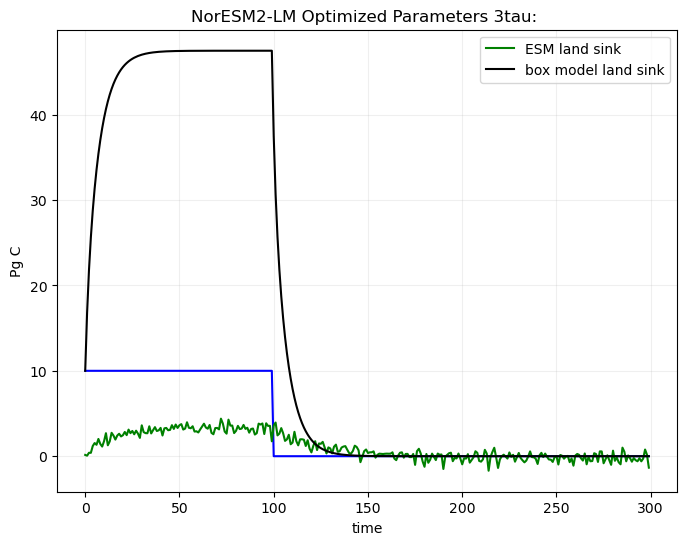

estimating parameters for model: MPI-ESM1-2-LR
taus: 1.44, 7.07, 86.16
sensitivities: 0.507, 0.493, 0.000


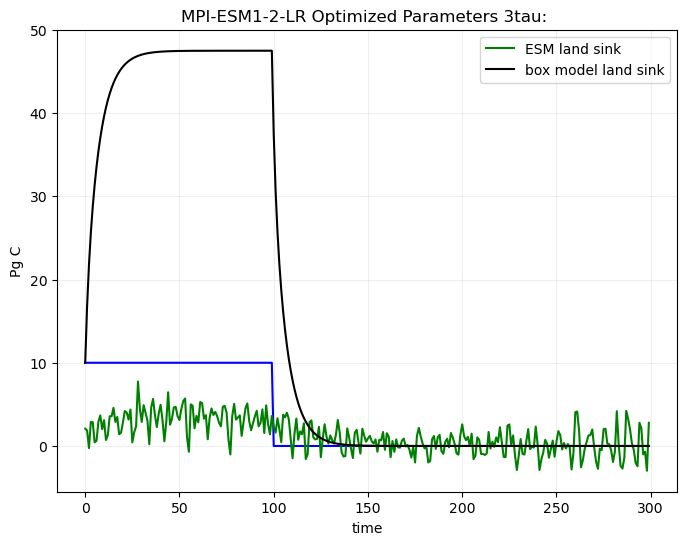

estimating parameters for model: CNRM-ESM2-1
taus: 1.44, 7.07, 86.08
sensitivities: 0.507, 0.493, 0.000


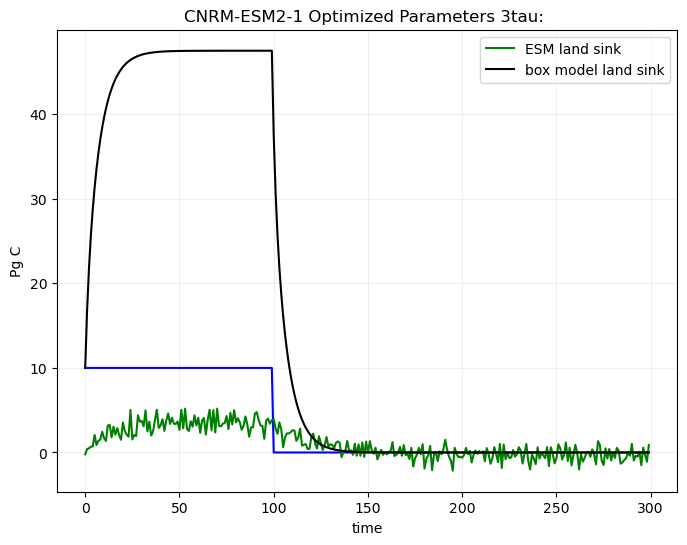

estimating parameters for model: HadCM3LC-Bris
taus: 1.44, 7.07, 86.04
sensitivities: 0.507, 0.493, 0.000


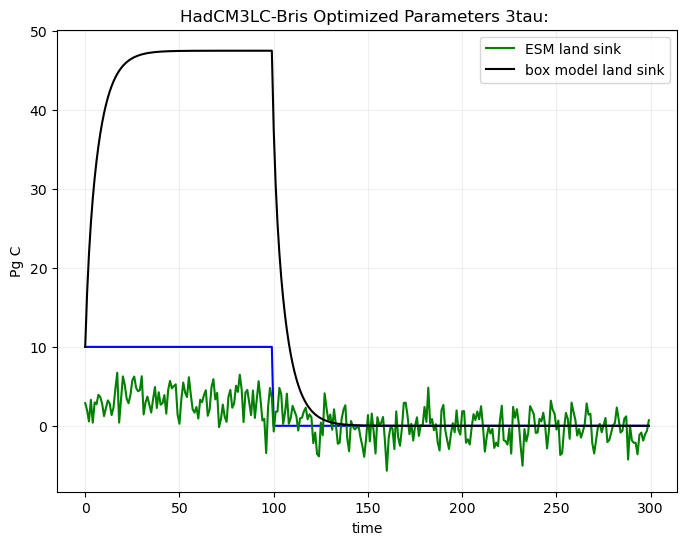

In [88]:
latrange='global'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year

# initialize some empty arrays to store outputs
tau1_vec=np.empty(len(modellist))
tau2_vec=np.empty(len(modellist))
tau3_vec=np.empty(len(modellist))
a1_vec=np.empty(len(modellist))
a2_vec=np.empty(len(modellist))
a3_vec=np.empty(len(modellist))

# define the emissions time series
emiss=emiss_flat10zec

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output
  
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    sink_obs=NBP

    #--- model fit
    # initial guess
    p0 = [2.0, 10.0, 100.0, 0.3, 0.3]  # tau1, tau2, tau3, sens1, sens2

    # bounds
    bounds_lower = [0.5, 1.0, 5.0, 0.0, 0.0]
    bounds_upper = [100.0, 200.0, 1000.0, 1.0, 1.0]

    # fit model using curve_fit
    popt, pcov = curve_fit(memory_model_3timescale_constrained_safe,
                           emiss, sink_obs,
                           p0=p0, bounds=(bounds_lower, bounds_upper))

   
    # Extract parameters
    tau1, tau2, tau3, sens1, sens2 = popt
    sens3=1-(sens1+sens2)
    print(f"taus: {tau1:.2f}, {tau2:.2f}, {tau3:.2f}")
    print(f"sensitivities: {sens1:.3f}, {sens2:.3f}, {sens3:.3f}")
    
    
    pred_totalsink_3timescale_zec = memory_model_3timescale_constrained_safe(emiss, 
                                                      tau1, 
                                                      tau2, 
                                                      tau3, 
                                                      sens1, 
                                                      sens2
                                                     )

    plt.figure(figsize=(8, 6))    
    plt.plot(emiss, color='blue')
    plt.plot(sink_obs, color='green',label='ESM land sink')
    plt.plot(pred_totalsink_3timescale_zec, color='black',label='box model land sink')
    # plt.plot(time_cdr, pred_totalsink_zec, color='black', linestyle='dashed')
    
    # plt.plot(time_zec, emiss_zec, color='blue')
    # plt.plot(time_zec, oceansink_zec+landsink_zec, color='green')
    # plt.plot(time_zec, pred_totalsink_2timescale_zec, color='black')
    # plt.plot(time_cdr, pred_totalsink_zec, color='black', linestyle='dashed')
    
    
    # plt.title('Carbon Fluxes, flat10-zec')
    plt.title(model +f' Optimized Parameters 3tau: ' )
    #             +f'tau1={(tau1_opt):.2f}, '
    #             +f'tau2={(tau2_opt):.2f}, '
    #             +f'tau3={(tau3_opt):.2f}, '
    #             +f'a1={a1_opt:.2f},'
    #             +f'a2={a2_opt:.2f},'
    #             +f'a3={a3_opt:.2f} '
    #              )
    plt.ylabel('Pg C')
    plt.xlabel('time')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


    tau1_vec[m]=tau1
    tau2_vec[m]=tau2
    tau3_vec[m]=tau3
    a1_vec[m]=sens1
    a2_vec[m]=sens2
    a3_vec[m]=sens3
    
# # #-- add output to a pandas data frame
# esm_boxfit = pd.DataFrame({})
# esm_boxfit['fV']=fV_vec
# esm_boxfit['fL']=fL_vec
# esm_boxfit['fS']=fS_vec
# esm_boxfit['Q10']=Q10_vec

# esm_boxfit.index=modellist

# esm_boxfit_global_zec=esm_boxfit

In [60]:
# Charlie's model
# 2 tau
def memory_2timescale(emissions, tau1, tau2, sens1, sens2):
    nt = len(emissions)
    sink = np.zeros(nt)
    for t in range(nt):
        r = 0
        for tt in range(t):
            r = r + emissions[tt] * (sens1 * np.exp(-(t-tt)/tau1) + sens2 * np.exp(-(t-tt)/tau2))
        sink[t] = r
    return sink

# 1 tau
def memory(emissions, tau, sens):
    nt = len(emissions)
    sink = np.zeros(nt)
    for t in range(nt):
        r = 0
        for tt in range(t):
            r = r + emissions[tt] * sens * np.exp(-(t-tt)/tau)
        sink[t] = r
    return sink
    

In [61]:
# trying Charlie's fit

emiss_zec=emiss_flat10zec

params_combined_2timescale, fit_combined_2timescale = scipy.optimize.curve_fit(memory_2timescale, emiss_zec, NBP, [10., 100., 0.02, 0.001])
print(params_combined_2timescale)



[6.61895016e+00 6.60295474e+00 5.33676872e-02 1.68696780e-03]


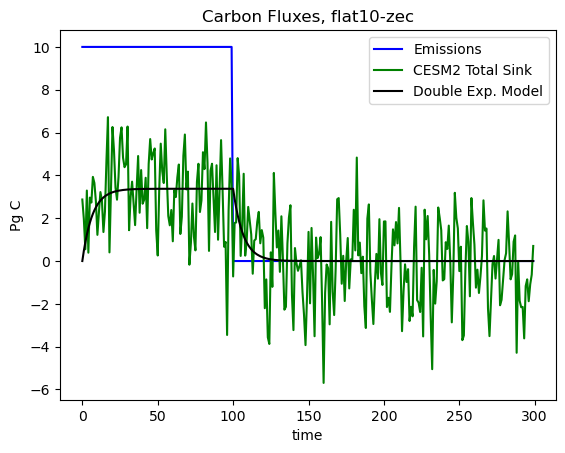

In [63]:

pred_totalsink_2timescale_zec = memory_2timescale(emiss_zec, params_combined_2timescale[0], params_combined_2timescale[1], params_combined_2timescale[2], params_combined_2timescale[3])

plt.plot(emiss_zec, color='blue')
plt.plot(NBP, color='green')
plt.plot(pred_totalsink_2timescale_zec, color='black')
# plt.plot(time_cdr, pred_totalsink_zec, color='black', linestyle='dashed')

# plt.plot(time_zec, emiss_zec, color='blue')
# plt.plot(time_zec, oceansink_zec+landsink_zec, color='green')
# plt.plot(time_zec, pred_totalsink_2timescale_zec, color='black')
# plt.plot(time_cdr, pred_totalsink_zec, color='black', linestyle='dashed')


plt.title('Carbon Fluxes, flat10-zec')
plt.ylabel('Pg C')
plt.xlabel('time')
plt.legend(['Emissions','CESM2 Total Sink','Double Exp. Model', 'Single Exp. Model'])

In [64]:
def memory_model_2timescale(emissions, tau1, tau2, sens1, sens2):
    nt = len(emissions)
    kernel = (sens1 * np.exp(-np.arange(nt) / tau1) +
              sens2 * np.exp(-np.arange(nt) / tau2))
    
    sink = np.convolve(emissions, kernel)[:nt]
    return sink

In [65]:
def memory_model_2timescale_constrained(emissions, tau1, tau2, sens1):
    sens2 = 1.0 - sens1
    nt = len(emissions)
    kernel = (sens1 * np.exp(-np.arange(nt) / tau1) +
              sens2 * np.exp(-np.arange(nt) / tau2))
    return np.convolve(emissions, kernel)[:nt]

tau1=0.03, tau2=9.22, sens1=0.1063, sens2=0.0242


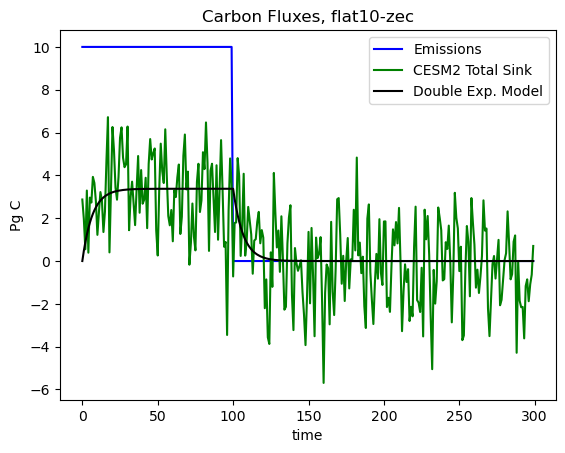

In [67]:
from scipy.optimize import curve_fit

# Fit the model
popt, pcov = curve_fit(memory_model_2timescale, emiss, sink_obs,
                       p0=[2.0, 10.0, 0.5, 0.5], bounds=(0, np.inf))

tau1, tau2, sens1, sens2 = popt
print(f"tau1={tau1:.2f}, tau2={tau2:.2f}, sens1={sens1:.4f}, sens2={sens2:.4f}")

pred_totalsink_2timescale_zec = memory_2timescale(emiss_zec, params_combined_2timescale[0], params_combined_2timescale[1], params_combined_2timescale[2], params_combined_2timescale[3])

plt.plot(emiss_zec, color='blue')
plt.plot(NBP, color='green')
plt.plot(pred_totalsink_2timescale_zec, color='black')
# plt.plot(time_cdr, pred_totalsink_zec, color='black', linestyle='dashed')

# plt.plot(time_zec, emiss_zec, color='blue')
# plt.plot(time_zec, oceansink_zec+landsink_zec, color='green')
# plt.plot(time_zec, pred_totalsink_2timescale_zec, color='black')
# plt.plot(time_cdr, pred_totalsink_zec, color='black', linestyle='dashed')


plt.title('Carbon Fluxes, flat10-zec')
plt.ylabel('Pg C')
plt.xlabel('time')
plt.legend(['Emissions','CESM2 Total Sink','Double Exp. Model', 'Single Exp. Model'])

In [72]:
def memory_model_3timescale(emissions, tau1, tau2, tau3, sens1, sens2, sens3):
    nt = len(emissions)
    t = np.arange(nt)
    
    # Build the memory kernel
    kernel = (sens1 * np.exp(-t / tau1) +
              sens2 * np.exp(-t / tau2) +
              sens3 * np.exp(-t / tau3))
    
    # Convolve and truncate
    sink = np.convolve(emissions, kernel)[:nt]
    return sink

In [73]:
def memory_model_3timescale_constrained_safe(emissions, tau1, tau2, tau3, sens1, sens2):
    sens3 = 1.0 - sens1 - sens2

    if sens3 < 0 or sens3 > 1:
        return np.full_like(emissions, 1e10)  # Penalize invalid sensitivity

    nt = len(emissions)
    max_lag = min(nt, int(max(tau1, tau2, tau3) * 10))
    t = np.arange(max_lag)

    kernel = (sens1 * np.exp(-t / tau1) +
              sens2 * np.exp(-t / tau2) +
              sens3 * np.exp(-t / tau3))

    sink = np.convolve(emissions, kernel)[:nt]
    return sink


In [74]:
p0 = [2.0, 10.0, 100.0, 0.3, 0.3]  # tau1, tau2, tau3, sens1, sens2

bounds_lower = [0.5, 1.0, 5.0, 0.0, 0.0]
bounds_upper = [100.0, 200.0, 1000.0, 1.0, 1.0]

popt, pcov = curve_fit(memory_model_3timescale_constrained_safe,
                       emiss, sink_obs,
                       p0=p0, bounds=(bounds_lower, bounds_upper))


taus: 1.44, 7.07, 86.04
sensitivities: 0.507, 0.493, 0.000


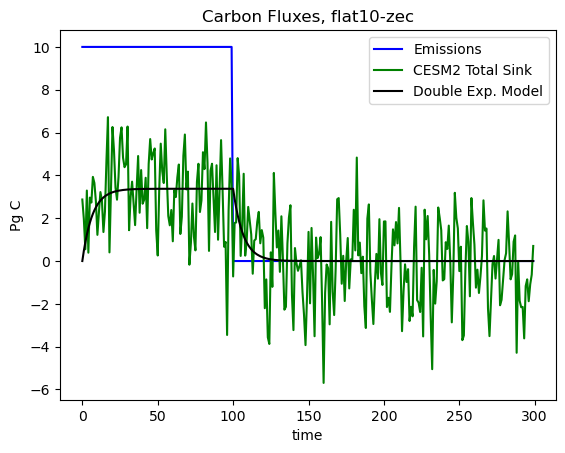

In [76]:
# from scipy.optimize import curve_fit

# # Example initial guess
# p0 = [2.0, 10.0, 50.0, 0.3, 0.3, 0.4]

# # Fit to observed data
# popt, pcov = curve_fit(memory_model_3timescale, emiss, sink_obs, p0=p0)

# Extract parameters
tau1, tau2, tau3, sens1, sens2 = popt
sens3=1-(sens1+sens2)
print(f"taus: {tau1:.2f}, {tau2:.2f}, {tau3:.2f}")
print(f"sensitivities: {sens1:.3f}, {sens2:.3f}, {sens3:.3f}")


pred_totalsink_3timescale_zec = memory_model_3timescale(emiss_zec, 
                                                  tau1, 
                                                  tau2, 
                                                  tau3, 
                                                  sens1, 
                                                  sens2, 
                                                  sens3
                                                 )

plt.plot(emiss_zec, color='blue')
plt.plot(NBP, color='green')
plt.plot(pred_totalsink_2timescale_zec, color='black')
# plt.plot(time_cdr, pred_totalsink_zec, color='black', linestyle='dashed')

# plt.plot(time_zec, emiss_zec, color='blue')
# plt.plot(time_zec, oceansink_zec+landsink_zec, color='green')
# plt.plot(time_zec, pred_totalsink_2timescale_zec, color='black')
# plt.plot(time_cdr, pred_totalsink_zec, color='black', linestyle='dashed')


plt.title('Carbon Fluxes, flat10-zec')
plt.ylabel('Pg C')
plt.xlabel('time')
plt.legend(['Emissions','CESM2 Total Sink','Double Exp. Model', 'Single Exp. Model'])

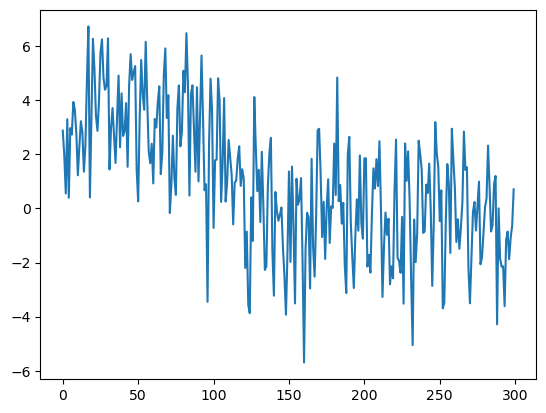

In [55]:
plt.plot(sink_obs)

estimating parameters for model: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 3.559662547595641
        x: [ 1.000e+01  5.000e+01  1.000e+02  3.300e-01  3.300e-01
             3.300e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00]
     nfev: 7
     njev: 1
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


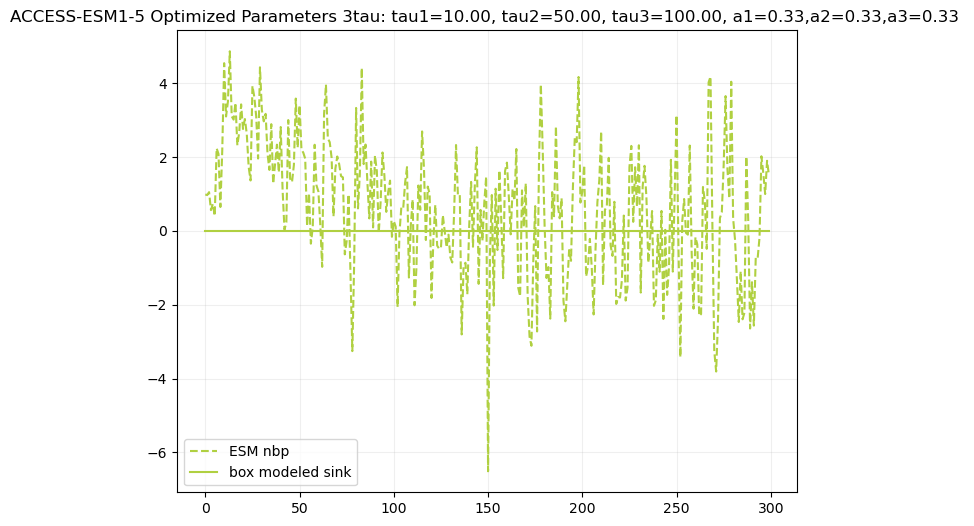

estimating parameters for model: CESM2
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 3.6647707918555086
        x: [ 1.000e+01  5.000e+01  1.000e+02  3.300e-01  3.300e-01
             3.300e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00 -4.441e-08  0.000e+00
             0.000e+00]
     nfev: 7
     njev: 1
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


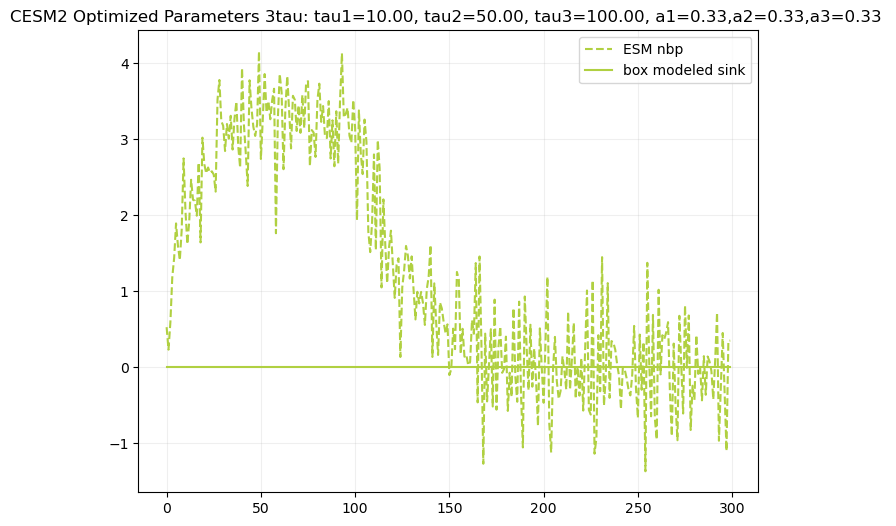

estimating parameters for model: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 6.591256351657057
        x: [ 1.000e+01  5.000e+01  1.000e+02  3.300e-01  3.300e-01
             3.300e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00]
     nfev: 7
     njev: 1
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


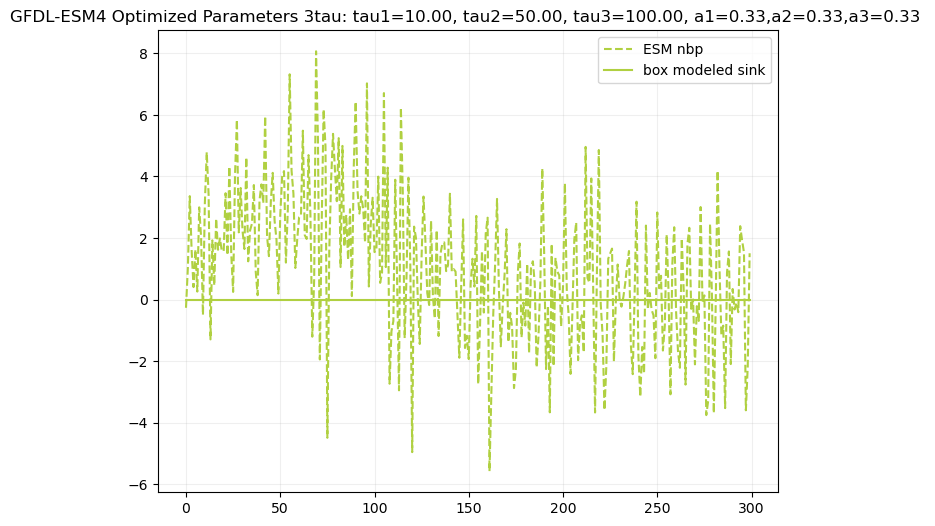

estimating parameters for model: GISS_E2.1
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.2515049371100459
        x: [ 1.000e+01  5.000e+01  1.000e+02  3.300e-01  3.300e-01
             3.300e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00]
     nfev: 7
     njev: 1
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


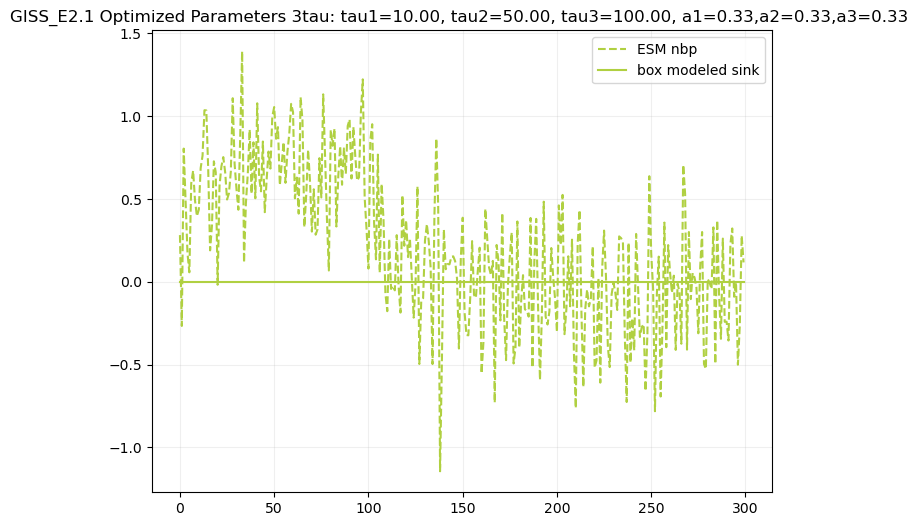

estimating parameters for model: NorESM2-LM
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 3.5507953738045375
        x: [ 1.000e+01  5.000e+01  1.000e+02  3.300e-01  3.300e-01
             3.300e-01]
      nit: 0
      jac: [-4.441e-08  0.000e+00  0.000e+00 -4.441e-08  0.000e+00
             0.000e+00]
     nfev: 7
     njev: 1
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


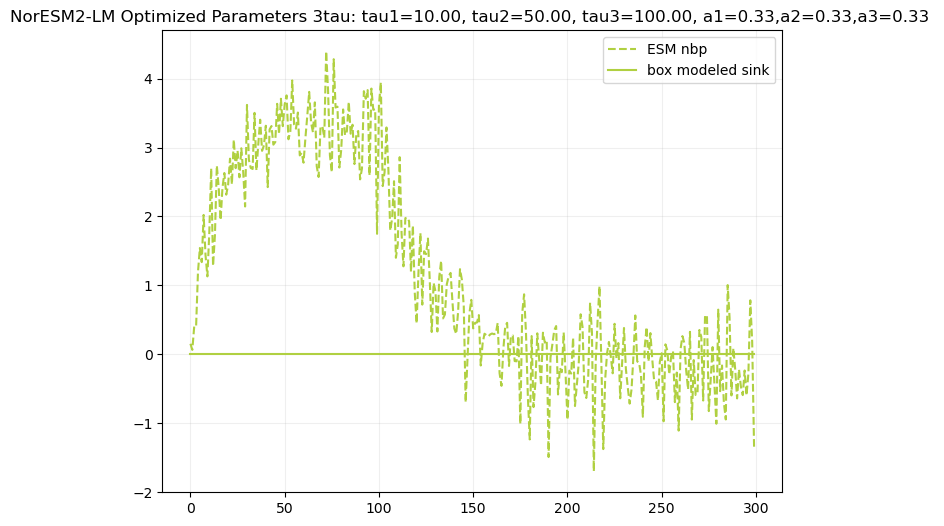

estimating parameters for model: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 5.939090528081385
        x: [ 1.000e+01  5.000e+01  1.000e+02  3.300e-01  3.300e-01
             3.300e-01]
      nit: 0
      jac: [-8.882e-08  0.000e+00  0.000e+00 -1.776e-07  0.000e+00
             0.000e+00]
     nfev: 7
     njev: 1
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


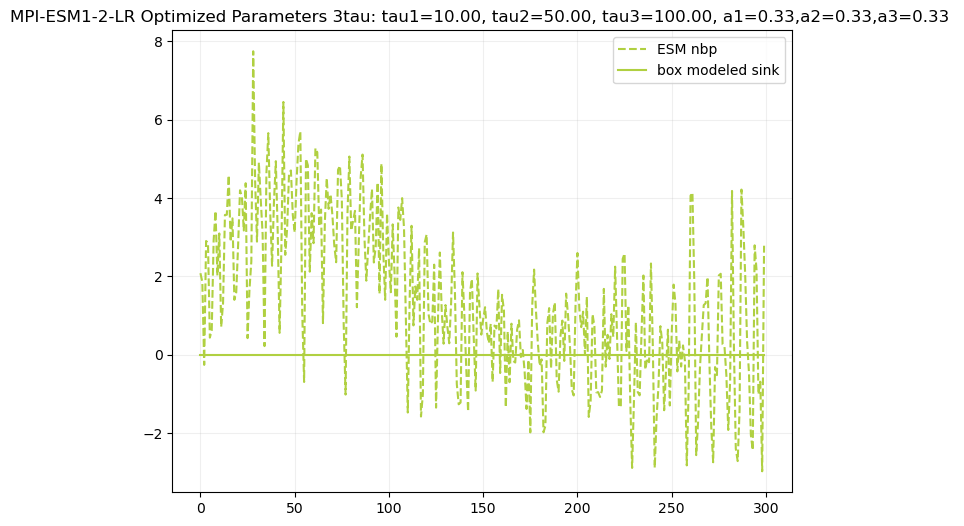

estimating parameters for model: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 4.436671822492196
        x: [ 1.000e+01  5.000e+01  1.000e+02  3.300e-01  3.300e-01
             3.300e-01]
      nit: 0
      jac: [-8.882e-08  0.000e+00  0.000e+00 -8.882e-08  0.000e+00
             0.000e+00]
     nfev: 7
     njev: 1
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


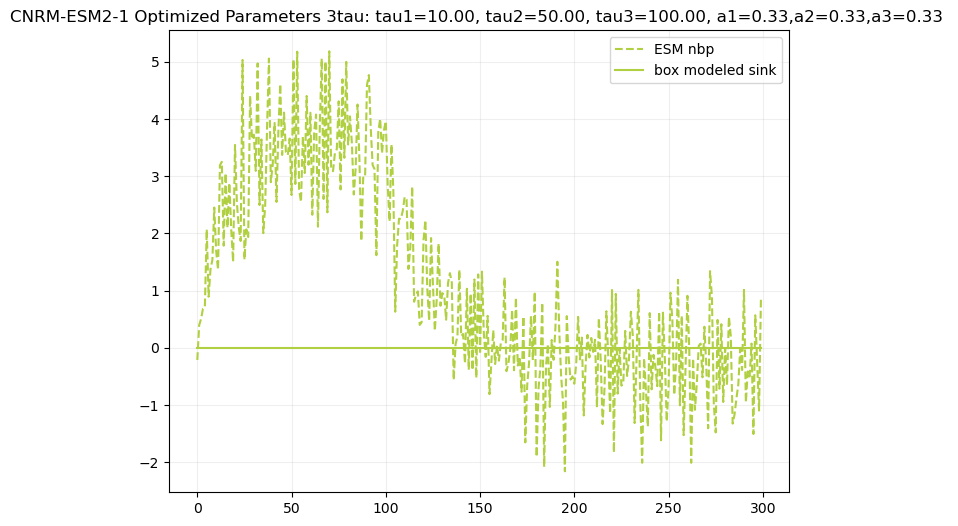

estimating parameters for model: HadCM3LC-Bris
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 6.988015975007887
        x: [ 1.000e+01  5.000e+01  1.000e+02  3.300e-01  3.300e-01
             3.300e-01]
      nit: 0
      jac: [ 1.776e-07  0.000e+00  0.000e+00  1.776e-07  0.000e+00
             0.000e+00]
     nfev: 7
     njev: 1
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


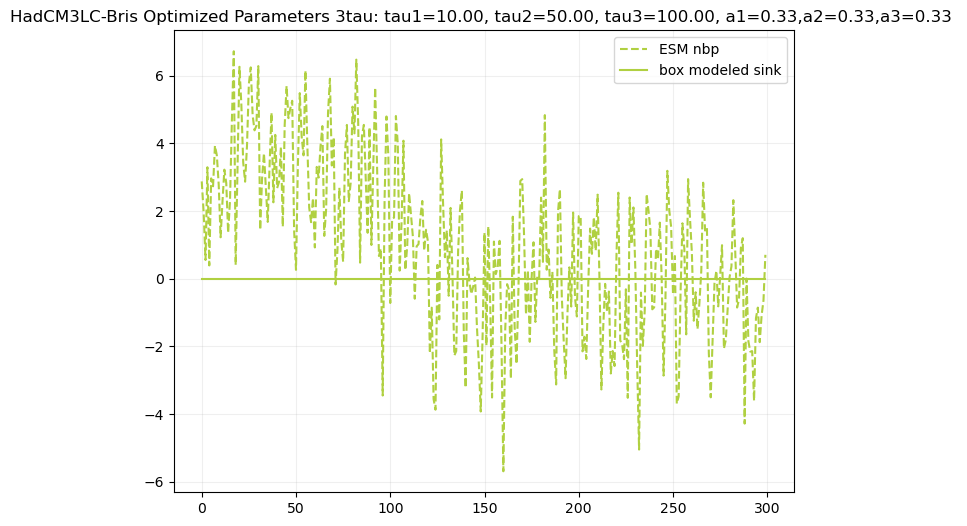

In [46]:
latrange='global'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year

# initialize some empty arrays to store outputs
tau1_vec=np.empty(len(modellist))
tau2_vec=np.empty(len(modellist))
tau3_vec=np.empty(len(modellist))
a1_vec=np.empty(len(modellist))
a2_vec=np.empty(len(modellist))
a3_vec=np.empty(len(modellist))

# define the emissions time series
emiss=emiss_flat10zec

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output
  
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr

    # Initial guess and bounds
    initial_guess = [10, 50, 100, .33,.33,.33] # first guess for [tau1, tau2, tau3, a1, a2, a3]
    bounds = [(1e-3, 1e3),(1e-3, 1e3),(1e-3, 1e3), (1e-3, 1), (1e-3, 1), (1e-3, 1)] #bounds for guesses
    
    # Run optimization
    result = minimize(objective_3tau, x0=initial_guess, bounds=bounds)
    tau1_opt, tau2_opt, tau3_opt, a1_opt, a2_opt, a3_opt = result.x
    print("Optimization Result:", result)
    
    # Simulate with optimal parameters
    sink_best = simulate_model_3tau(result.x)
    
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.plot(NBP, label='ESM nbp',color=vegcolor,linestyle='--')
    plt.plot(sink_best, label=f'box modeled sink',color=vegcolor)
    plt.legend()
    plt.title(model +f' Optimized Parameters 3tau: ' 
                +f'tau1={(tau1_opt):.2f}, '
                +f'tau2={(tau2_opt):.2f}, '
                +f'tau3={(tau3_opt):.2f}, '
                +f'a1={a1_opt:.2f},'
                +f'a2={a2_opt:.2f},'
                +f'a3={a3_opt:.2f} '
                 )
    plt.grid(alpha=0.2)
    plt.show()

    tau1_vec[m]=tau1_opt
    tau2_vec[m]=tau2_opt
    tau3_vec[m]=tau3_opt
    a1_vec[m]=a1_opt
    a2_vec[m]=a2_opt
    a3_vec[m]=a3_opt
    
# # #-- add output to a pandas data frame
# esm_boxfit = pd.DataFrame({})
# esm_boxfit['fV']=fV_vec
# esm_boxfit['fL']=fL_vec
# esm_boxfit['fS']=fS_vec
# esm_boxfit['Q10']=Q10_vec

# esm_boxfit.index=modellist

# esm_boxfit_global_zec=esm_boxfit

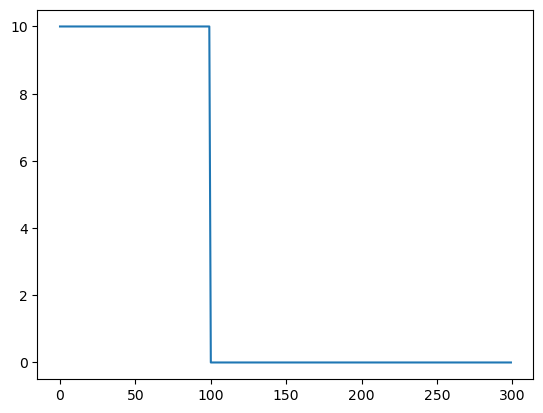

In [43]:
plt.plot(emiss)

In [24]:
np.shape(NBP)

(300,)

In [25]:
# define emissions time series
emiss = np.empty(300)
emiss[0:100]=10
emiss[-100:]=0


np.shape(emiss)

(300,)

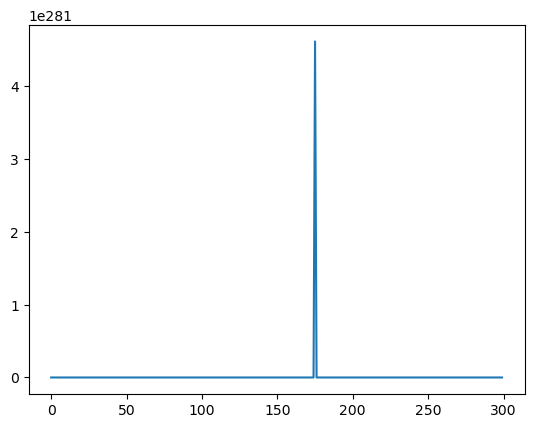

In [33]:
plt.plot(emiss)

In [38]:
emiss

array([1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1.00000000e+001, 1.00000000e+001, 1.00000000e+001,
       1.00000000e+001, 1

In [29]:
# fit every gridcell individually
# Create a Dask client with 8 workers 

# client = Client(n_workers=8)


params_list = []

#--- model fit bounds and initial guesses
# initial guess
p0 = [2.0, 10.0,  0.02,0.001]  # tau1, tau2, tau3, sens1, sens2

# bounds
bounds_lower = [0.5, 1.0, 0.0, 0.0]
bounds_upper = [100.0, 1000.0, 1.0,1.0]

# define the emissions time series
emissions=emiss_flat10zec

unitconvert=PgperKg

# loop over models
for m in range(1):#len(modellist)):
    model=modellist[m]
    print('Fitting 2 box model to: ' +model)

    mcolor=modelcolors[m]

    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'nbp')

    ###---- grid info
    lat = ds0g.lat
    lon = ds0g.lon
    
    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')

    #----###-----####----- nbp
    var='nbp'
    # flat 10 emissions phase
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    del ds0 # drop first ds grid from memory   
    dst_0= select_time_slice(dsw, 0, 99) # first 100 years of flat10
    # dst_PgC = unitconvert*(dst*landarea) # converted to PgC
    
    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    dsw=weighted_temporal_mean(ds1,var)
    del ds1 # drop full grid from memory
    dst_1= select_time_slice(dsw, 0, 200) # first 100 years of flat10
    dst=xr.concat([dst_0,dst_1],dim='time')
    ds_PgC = unitconvert*(dst*landarea)# converted to PgC
  
    #  drop some things from memory
    # del dst_0, dst

    # plt.plot(dst.sum(dim=['lat','lon']))

    # # Apply the fitting process across the grid
    param_grid = fit_grid_2timescale(emissions, ds_PgC.values)

    # Fit the model across the 2D grid using Dask
    # param_grid = fit_grid_2timescale_dask(emissions, ds_PgC.values)

    # param_grid = np.zeros((m, len(lat),len(lon), 4)) #store parameters
    
    # # loop over all lat and lon
    # for lt in range(len(lat)):
    #     for ln in range(len(lon)):
    #         sink_obs=ds_PgC[:,lt,ln].values
    #         emiss=emissions[0:(len(sink_obs)+1)]

    #         # IRF model fit
    #         try:
    #             popt, _ = curve_fit(fit_wrapper2, np.arange(len(emiss)), sink_obs,
    #                                    bounds=(bounds_lower, bounds_upper))
    #             param_grid[lt, ln] = popt  # Store the optimized parameters
    #         except Exception as e:
    #             print(f"Fit failed at grid point ({lt}, {ln}): {e}")
    #             param_grid[lt, ln] = np.nan  # Mark as NaN if fitting fails
            
            # tau1, tau2, sens1, sens2 = popt
            # box_model_pred_2=fit_wrapper2(np.arange(len(emiss)),tau1,tau2,sens1,sens2)

            # tau1_mat[lt,ln]=tau1
            # tau2_mat[lt,ln]=tau2
            # sens1_mat[lt,ln]=sens1
            # sens2_mat[lt,ln]=sens2
            
            # params_list.append(popt) 

Fitting 2 box model to: ACCESS-ESM1-5
loading variable: nbp
finished loading ACCESS-ESM1-5 *lat10 nbp
loading variable: nbp
finished loading ACCESS-ESM1-5 *lat10 nbp
loading variable: nbp
finished loading ACCESS-ESM1-5 *zec nbp
Fit failed at grid point (0, 0): array must not contain infs or NaNs
Fit failed at grid point (0, 1): array must not contain infs or NaNs
Fit failed at grid point (0, 2): array must not contain infs or NaNs
Fit failed at grid point (0, 3): array must not contain infs or NaNs
Fit failed at grid point (0, 4): array must not contain infs or NaNs
Fit failed at grid point (0, 5): array must not contain infs or NaNs
Fit failed at grid point (0, 6): array must not contain infs or NaNs
Fit failed at grid point (0, 7): array must not contain infs or NaNs
Fit failed at grid point (0, 8): array must not contain infs or NaNs
Fit failed at grid point (0, 9): array must not contain infs or NaNs
Fit failed at grid point (0, 10): array must not contain infs or NaNs
Fit failed a